# Lending Club - Lending Risk Analysis

## Introduction

This note book details the analysis and the approach followed to investigate the driving factors behind the charged off loans.<br>
The observations considered for the analysis are loan applications during the period 2007 - 2011. <br>
The observations are the loans that are accepted by LC and eventually fully paid or charged off. <br>
All the Inferences and Assumptions will follow the code instructions.The comments are embidded inside the code fragments.<br>
<br>

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import missingno as msno
import zipcodes as zc
import plotly as py
import plotly.graph_objs as go

In [2]:
# Set the session options
%matplotlib inline
pd.options.display.max_columns = None
#pd.options.display.max_rows = None
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
# Read file and let Python detect the variable types at the cost of memory, rather than guessing the dtypes.
loan=pd.read_csv(r'C:\Users\santo\Documents\PGDML\Course-1\Group_Project\loan.csv',low_memory=False)

## Data Cleaning 

This section covers the Data Cleaning actions. The following is the high level Data cleaning approach - 
 - Remove all the columns that have no data.
 - Remove all the rows that have no data.
 - Remove all the columns that have single unique value.
 - Remove all the columns that have NaNs in atleast 1/3rd of the total rows.
 - Investigate each column and cleanse the data or delete as appropriate.

In [4]:
# Get some idea on the data size and sample data 
print(loan.shape)
loan.head(2)

(39717, 111)


id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000         4,975.00   36 months   
1  1077430    1314167       2500         2500         2,500.00   60 months   

  int_rate  installment grade sub_grade emp_title emp_length home_ownership  \
0   10.65%       162.87     B        B2       NaN  10+ years           RENT   
1   15.27%        59.83     C        C4     Ryder   < 1 year           RENT   

   annual_inc verification_status issue_d  loan_status pymnt_plan  \
0   24,000.00            Verified  Dec-11   Fully Paid          n   
1   30,000.00     Source Verified  Dec-11  Charged Off          n   

                                                 url  \
0  https://lendingclub.com/browse/loanDetail.acti...   
1  https://lendingclub.com/browse/loanDetail.acti...   

                                                desc      purpose     title  \
0    Borrower added on 12/22/11 > I need to upgra...  credit_card  Computer   
1    Borrower added on 12/22/11 > I plan to use t...          car      bike   

  zip_code addr_state   dti  delinq_2yrs earliest_cr_line  inq_last_6mths  \
0    860xx         AZ 27.65            0           Jan-85               1   
1    309xx         GA  1.00            0           Apr-99               5   

   mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  \
0                     nan                     nan         3        0   
1                     nan                     nan         3        0   

   revol_bal revol_util  total_acc initial_list_status  out_prncp  \
0      13648     83.70%          9                   f       0.00   
1       1687      9.40%          4                   f       0.00   

   out_prncp_inv  total_pymnt  total_pymnt_inv  total_rec_prncp  \
0           0.00     5,863.16         5,833.84         5,000.00   
1           0.00     1,008.71         1,008.71           456.46   

   total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee  \
0         863.16                0.00        0.00                     0.00   
1         435.17                0.00      117.08                     1.11   

  last_pymnt_d  last_pymnt_amnt next_pymnt_d last_credit_pull_d  \
0       Jan-15           171.62          NaN             May-16   
1       Apr-13           119.66          NaN             Sep-13   

   collections_12_mths_ex_med  mths_since_last_major_derog  policy_code  \
0                        0.00                          nan            1   
1                        0.00                          nan            1   

  application_type  annual_inc_joint  dti_joint  verification_status_joint  \
0       INDIVIDUAL               nan        nan                        nan   
1       INDIVIDUAL               nan        nan                        nan   

   acc_now_delinq  tot_coll_amt  tot_cur_bal  open_acc_6m  open_il_6m  \
0               0           nan          nan          nan         nan   
1               0           nan          nan          nan         nan   

   open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  \
0          nan          nan                 nan           nan      nan   
1          nan          nan                 nan           nan      nan   

   open_rv_12m  open_rv_24m  max_bal_bc  all_util  total_rev_hi_lim  inq_fi  \
0          nan          nan         nan       nan               nan     nan   
1          nan          nan         nan       nan               nan     nan   

   total_cu_tl  inq_last_12m  acc_open_past_24mths  avg_cur_bal  \
0          nan           nan                   nan          nan   
1          nan           nan                   nan          nan   

   bc_open_to_buy  bc_util  chargeoff_within_12_mths  delinq_amnt  \
0             nan      nan                      0.00            0   
1             nan      nan                      0.00            0   

   mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  \
0    

In [5]:
# Drop columns and Rows that have no Data.
loan_data=loan.dropna(axis='columns',how='all')
loan_data=loan_data.dropna(axis='rows',how='all')

#Drop columns that have same values
loan_unique=loan_data.nunique().sort_values()
unique_cols=loan_unique[loan_unique==1].index
loan_data.drop(columns=unique_cols,axis=1,inplace=True)

#Ignore columns that have atleast one-third of Nil values 
loan_data = loan_data.loc[:, (loan_data.isnull().sum(axis=0) <= len(loan_data)/3)]

#Now get the final size and remaining columns
print(loan_data.shape)

(39717, 45)


In [6]:
# Check the distribution of NaN across the columns
loan_data[loan_data.columns[loan_data.isnull().any()]].head(1)


emp_title emp_length                                               desc  \
0       NaN  10+ years    Borrower added on 12/22/11 > I need to upgra...   

      title revol_util last_pymnt_d last_credit_pull_d  pub_rec_bankruptcies  
0  Computer     83.70%       Jan-15             May-16                  0.00

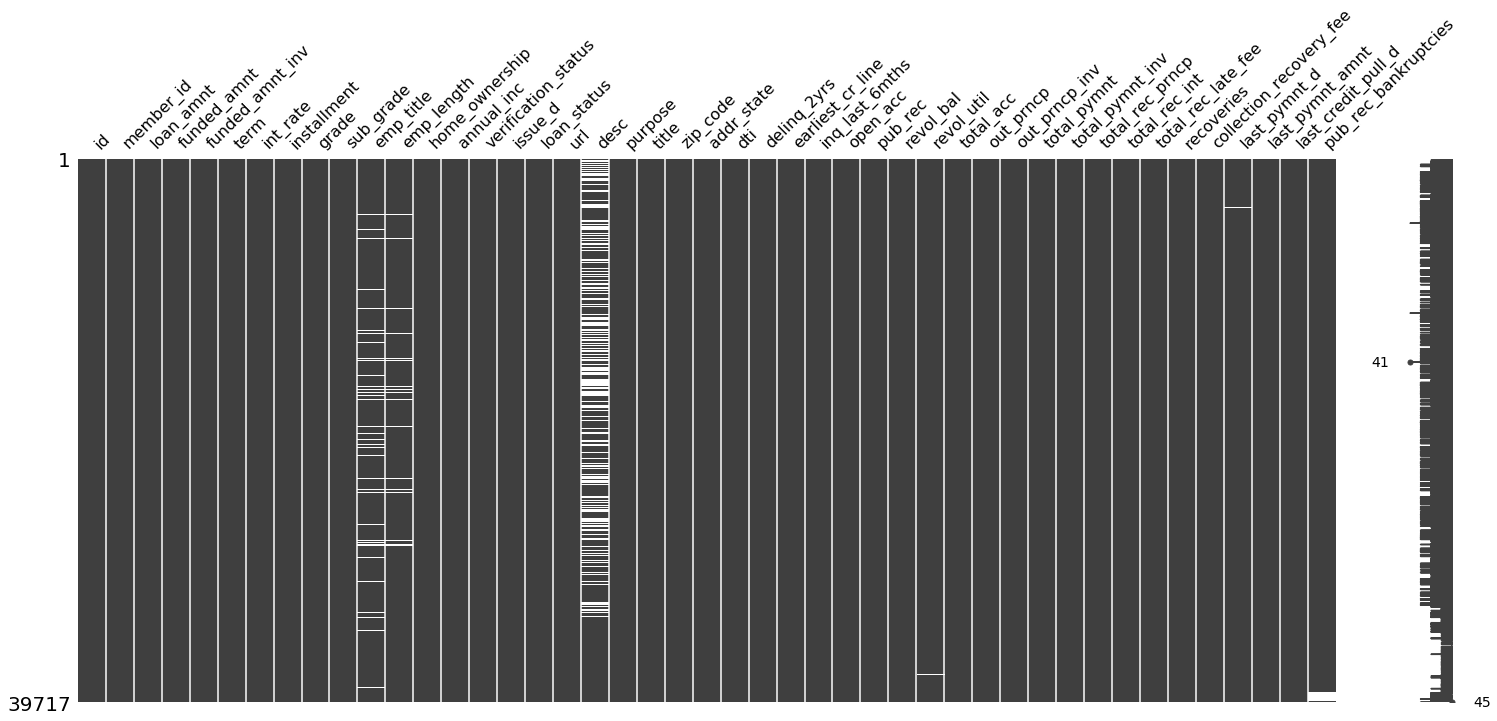

In [7]:
msno.matrix(loan_data)

Now clean and treat each variable in the data set

In [8]:
loan_data.describe()

id    member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
count    39,717.00    39,717.00  39,717.00    39,717.00        39,717.00   
mean    683,131.91   850,463.56  11,219.44    10,947.71        10,397.45   
std     210,694.13   265,678.31   7,456.67     7,187.24         7,128.45   
min      54,734.00    70,699.00     500.00       500.00             0.00   
25%     516,221.00   666,780.00   5,500.00     5,400.00         5,000.00   
50%     665,665.00   850,812.00  10,000.00     9,600.00         8,975.00   
75%     837,755.00 1,047,339.00  15,000.00    15,000.00        14,400.00   
max   1,077,501.00 1,314,167.00  35,000.00    35,000.00        35,000.00   

       installment   annual_inc       dti  delinq_2yrs  inq_last_6mths  \
count    39,717.00    39,717.00 39,717.00    39,717.00       39,717.00   
mean        324.56    68,968.93     13.32         0.15            0.87   
std         208.87    63,793.77      6.68         0.49            1.07   
min          15.69     4,000.00      0.00         0.00            0.00   
25%         167.02    40,404.00      8.17         0.00            0.00   
50%         280.22    59,000.00     13.40         0.00            1.00   
75%         430.78    82,300.00     18.60         0.00            1.00   
max       1,305.19 6,000,000.00     29.99        11.00            8.00   

       open_acc   pub_rec  revol_bal  total_acc  out_prncp  out_prncp_inv  \
count 39,717.00 39,717.00  39,717.00  39,717.00  39,717.00      39,717.00   
mean       9.29      0.06  13,382.53      22.09      51.23          50.99   
std        4.40      0.24  15,885.02      11.40     375.17         373.82   
min        2.00      0.00       0.00       2.00       0.00           0.00   
25%        6.00      0.00   3,703.00      13.00       0.00           0.00   
50%        9.00      0.00   8,850.00      20.00       0.00           0.00   
75%       12.00      0.00  17,058.00      29.00       0.00           0.00   
max       44.00      4.00 149,588.00      90.00   6,311.47       6,307.37   

       total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  \
count    39,717.00        39,717.00        39,717.00      39,717.00   
mean     12,153.60        11,567.15         9,793.35       2,263.66   
std       9,042.04         8,942.67         7,065.52       2,608.11   
min           0.00             0.00             0.00           0.00   
25%       5,576.93         5,112.31         4,600.00         662.18   
50%       9,899.64         9,287.15         8,000.00       1,348.91   
75%      16,534.43        15,798.81        13,653.26       2,833.40   
max      58,563.68        58,563.68        35,000.02      23,563.68   

       total_rec_late_fee  recoveries  collection_recovery_fee  \
count           39,717.00   39,717.00                39,717.00   
mean                 1.36       95.22                    12.41   
std                  7.29      688.74                   148.67   
min                  0.00        0.00                     0.00   
25%                  0.00        0.00                     0.00   
50%                  0.00        0.00                     0.00   
75%                  0.00        0.00                     0.00   
max                180.20   29,623.35                 7,002.19   

       last_pymnt_amnt  pub_rec_bankruptcies  
count        39,717.00             39,020.00  
mean          2,678.83                  0.04  
std           4,447.14                  0.20  
min               0.00                  0.00  
25%             218.68                  0.00  
50%             546.14                  0.00  
75%           3,293.16                  0.00  
max          36,115.20                  2.00

In [9]:
loan_data[loan_data['funded_amnt'] > loan_data['loan_amnt']]

Empty DataFrame
Columns: [id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, url, desc, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, pub_rec_bankruptcies]
Index: []

In [10]:
# Term - Check 'term' and remove the extra charecters 'Months'. Identify the unique values.
print('--- Term ----\n')
loan_data['term']=loan_data['term'].str.replace(' months','')
print(loan_data['term'].nunique())
print(loan_data['term'].unique())

# Loan Status - Convert loan_status to lower, remove any spaces and find unique values.
print('--- Loan Status ----\n')
loan_data['loan_status']=loan_data['loan_status'].str.strip().str.lower()
print(loan_data.loan_status.nunique())
print(loan_data.loan_status.unique())
print(loan_data.groupby(['loan_status'], as_index=False).size().reset_index(name='counts'))

# Employement Length - Replace the extraneous charecters in the employee length and impute the NaNs as 'Not Disclosed'
print('--- Employee Length ----\n')
loan_data['emp_length']=loan_data['emp_length'].str.strip().str.replace(' years','').str.replace('+','').str.replace('< 1','0').str.replace(' year','')
loan_data.emp_length.fillna(value='Not Disclosed',inplace=True)
print(loan_data.emp_length.unique())
print(loan_data.emp_length.describe())

# Investigate Annual income
print('--- Annual Income ----\n')
print(loan_data.annual_inc.median())

# Create a new derived column - log to the base 2 for annual income for analysis purpose
loan_data['annual_inc_log2']=np.log2(loan_data['annual_inc'])

# Issue Date - convert issue date to date time format
print('--- Issue Date ----\n')
loan_data['issue_date_dt']=pd.to_datetime(loan_data['issue_d'],format='%b-%y')
print(loan_data.issue_date_dt.describe())

# Dti - Identify the unique values
print('--- DTI ----\n')
print(loan_data.dti.nunique())

#delinq_2yrs - Number of 30+ months passed after delinquecy incidents in last 2 years.
print('--- delinq_2yrs ----\n')
print(loan_data.delinq_2yrs.nunique())
print(loan_data.delinq_2yrs.unique())
print(loan_data.groupby(by='delinq_2yrs')['id'].count())

#inq_last_6mth - Just check values
print('--- inq_last_6mth ----\n')
print(loan_data.inq_last_6mths.nunique())
print(loan_data.inq_last_6mths.unique())

#int_rate - apply the string cleaning and validate the nunique values
print('--- interest rate ----\n')
loan_data['int_rate_f']=loan_data['int_rate'].str.replace('%','').astype(float)
print(loan_data.int_rate_f.nunique())

#installemnt - Just check 
print('--- installment ----\n')
print(loan_data.installment.nunique())
print(loan_data.installment.describe())
print(loan_data.installment.median())

# pub_rec - Check the values
print('--- pub_rec ----\n')
print(loan_data.pub_rec.nunique())
print(loan_data.pub_rec.unique())

#pub_rec_bankruptcies - Impute 'Not known' for the bankruptcies record where the data is not available. 
print('--- pub_rec_bankruptcies ----\n')
print(loan_data.pub_rec_bankruptcies.unique())
loan_data.pub_rec_bankruptcies.fillna(value='Not Known',inplace=True)
print(loan_data.pub_rec_bankruptcies.unique())

# last_credit_pull_dt - Conver the format and validate the dates.
loan_data['last_credit_pull_dt']=pd.to_datetime(loan_data['last_credit_pull_d'],format='%b-%y')
print(loan_data['last_credit_pull_dt'].min())
print(loan_data['last_credit_pull_dt'].max())

# emp_title - Create a new derived column to categorize if the emp_title is disclosed or not
loan_data.emp_title.describe()
loan_data['emp_title_provided'] = np.where(np.logical_or(loan_data['emp_title'].isnull(), loan_data['emp_title'].str.strip() == ''), False, True)
loan_data['emp_title_provided']=loan_data['emp_title_provided'].apply(lambda x: 'Disclosed' if x is True else 'Not Disclosed')

# title - just check 
loan_data.title.describe()
loan_data.title.head(5)

--- Term ----

2
[' 36' ' 60']
--- Loan Status ----

3
['fully paid' 'charged off' 'current']
   loan_status  counts
0  charged off    5627
1      current    1140
2   fully paid   32950
--- Employee Length ----

['10' '0' '1' '3' '8' '9' '4' '5' '6' '2' '7' 'Not Disclosed']
count     39717
unique       12
top          10
freq       8879
Name: emp_length, dtype: object
--- Annual Income ----

59000.0
--- Issue Date ----

count                   39717
unique                     55
top       2011-12-01 00:00:00
freq                     2260
first     2007-06-01 00:00:00
last      2011-12-01 00:00:00
Name: issue_date_dt, dtype: object
--- DTI ----

2868
--- delinq_2yrs ----

11
[ 0  2  3  1  4  6  5  8  7  9 11]
delinq_2yrs
0     35405
1      3303
2       687
3       220
4        62
5        22
6        10
7         4
8         2
9         1
11        1
Name: id, dtype: int64
--- inq_last_6mth ----

9
[1 5 2 0 3 4 6 7 8]
--- interest rate ----

371
--- installment ----

15383
count   39,71

0                Computer
1                    bike
2    real estate business
3                personel
4                Personal
Name: title, dtype: object

### Observation
There is high variation of mean and median in annual income. So,clearly there are some outliers. 

### Home Owner ship

In [11]:
print(loan_data.home_ownership.unique())

['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']


In [12]:
# As per Data Dictionary, the values for howm ownership should be one of RENT' 'OWN' 'MORTGAGE' 'OTHER'.
# Convert them to lower case, stip out any spaces. 
# Identify how many are outside this designated category.
loan_data['home_ownership']=loan_data['home_ownership'].str.strip().str.lower()

# Values should be one of 'rent' 'own' 'mortgage' 'other' 
loan_data.groupby(by='home_ownership')['loan_amnt'].count()
loan_data[loan_data['home_ownership']=='none']


id  member_id  loan_amnt  funded_amnt  funded_amnt_inv term  \
39318  231321     214993      10000        10000         1,228.06   36   
39659  121568     121574       4000         4000         1,925.00   36   
39660  121535     121373       2800         2800         1,625.00   36   

      int_rate  installment grade sub_grade emp_title emp_length  \
39318    7.75%       312.22     A        A3       ups          5   
39659    9.64%       128.41     B        B4       NaN          0   
39660    8.70%        88.65     B        B1       NaN          0   

      home_ownership  annual_inc verification_status issue_d loan_status  \
39318           none   22,200.00        Not Verified  Jan-08  fully paid   
39659           none  100,000.00        Not Verified  Aug-07  fully paid   
39660           none  120,000.00        Not Verified  Aug-07  fully paid   

                                                     url  \
39318  https://lendingclub.com/browse/loanDetail.acti...   
39659  https://lendingclub.com/browse/loanDetail.acti...   
39660  https://lendingclub.com/browse/loanDetail.acti...   

                                                    desc             purpose  \
39318  I plan to pay off my credit cards, leaving me ...  debt_consolidation   
39659  I took a high interest loan from Citibank in 2...               other   
39660  The family is expanding in October and we are ...               other   

                                title zip_code addr_state   dti  delinq_2yrs  \
39318                 Melinda Holster    233xx         VA  5.24            0   
39659  Refinancing high interest loan    950xx         CA 15.00            0   
39660                  Baby is coming    024xx         MA 15.00            0   

      earliest_cr_line  inq_last_6mths  open_acc  pub_rec  revol_bal  \
39318           Apr-94               0         9        0       4767   
39659           May-99               1         6        0       8155   
39660           May-99               1         6        0       8155   

      revol_util  total_acc  out_prncp  out_prncp_inv  total_pymnt  \
39318      8.70%         22       0.00           0.00    11,239.62   
39659     14.90%          8       0.00           0.00     4,622.49   
39660     14.90%          8       0.00           0.00     3,191.22   

       total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
39318         1,380.00         9,999.99       1,239.63                0.00   
39659         2,224.58         4,000.00         622.49                0.00   
39660         1,852.05         2,800.00         391.22                0.00   

       recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt  \
39318        0.00                     0.00       Feb-11           313.59   
39659        0.00                     0.00       Sep-10           129.76   
39660        0.00                     0.00       Sep-10            89.80   

      last_credit_pull_d pub_rec_bankruptcies  annual_inc_log2 issue_date_dt  \
39318             Jan-11            Not Known            14.44    2008-01-01   
39659             Aug-07            Not Known            16.61    2007-08-01   
39660             Aug-07            Not Known            16.87    2007-08-01   

       int_rate_f last_credit_pull_dt emp_title_provided  
39318        7.75          2011-01-01          Disclosed  
39659        9.64          2007-08-01      Not Disclosed  
39660        8.70          2007-08-01      Not Disclosed

In [13]:
# There are only 3 such observatiions. These observations doesn't cause any issue to the charged off loan univariate analysis.
# When we drop them from 'Fully paid' data, it is only a small percentage.

loan_data.drop(loan_data[loan_data.home_ownership == 'none'].index, inplace=True)
print(loan_data.home_ownership.unique())

['rent' 'own' 'mortgage' 'other']


### Verification status

In [14]:
print(loan_data.verification_status.nunique())
print(loan_data.verification_status.unique())

3
['Verified' 'Source Verified' 'Not Verified']


In [15]:
# There are two categories here. Income verified or not. Source of income(employability) is verified or not. 
# We can derive new boolen column from income and source verification.

loan_data['source_verification'] = np.where(loan_data['verification_status'].str.strip() == 'Source Verified', True, False)
loan_data['income_verification'] = np.where(np.logical_or(loan_data['verification_status'].str.strip() == 'Verified', 
                                                    loan_data['verification_status'].str.strip() == 'Source Verified'), True, False)

print(loan_data.income_verification.nunique())
print(loan_data.income_verification.unique())
print(loan_data.source_verification.nunique())
print(loan_data.source_verification.unique())

2
[ True False]
2
[False  True]


### Purpose and Desc

In [16]:
loan_data['purpose']=loan_data['purpose'].str.strip().str.lower()
print(loan_data.purpose.describe())
print(loan_data.purpose.unique())
loan_data.grade.unique()

count                  39714
unique                    14
top       debt_consolidation
freq                   18640
Name: purpose, dtype: object
['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']


array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [17]:
# Genralise/Narrow down the loan purpose. For example, credit_card balance clearence is same as debit consolidation. 

purpose_map={'credit_card':'debt_consolidation',
            'car':'Auto',
             'small_business':'small_business',
             'other':'other',
             'wedding':'wedding',
             'debt_consolidation': 'debt_consolidation',
             'home_improvement':'home_improvement',
             'major_purchase':'major_purchase',
             'medical':'medical',
             'moving':'home_improvement',
             'vacation':'vacation',
             'house':'home_improvement',
             'renewable_energy':'home_improvement',
             'educational':'educational'
            }
loan_data['purpose_mapped']=loan_data['purpose'].map(purpose_map)

In [18]:
loan_data.groupby(by=['purpose_mapped'])['id'].count()

purpose_mapped
Auto                   1549
debt_consolidation    23770
educational             325
home_improvement       4043
major_purchase         2187
medical                 693
other                  3991
small_business         1828
vacation                381
wedding                 947
Name: id, dtype: int64

In [19]:
# Impute 'Not Disclosed' in the 'Desc' column for NaNs
loan_data.desc.fillna(value='Not Disclosed',inplace=True)
print(loan_data.desc.describe())

count             39714
unique            26525
top       Not Disclosed
freq              12940
Name: desc, dtype: object


### Observation 
 - From eye ball checks, it is evident that some of the loans are availed for debt consolidation. 
 - For example, with reason of wedding, loan was availed to clear off credit card balance. 
So process mapping will need to be done. Do a generic search for the work 'consolidate' and categorise the 'purpose'.
 - We can only use the work 'pay off', but that will map some genuine observations. For this exercise we considered only 'consolidate'

In [20]:
# Apply the changes on 'purpose_mapped' as mentioned above.

a='consolidate'
temp_frame_non_dbtc=loan_data[loan_data['purpose_mapped']!='debt_consolidation']
temp_frame_dbtc=loan_data[loan_data['purpose_mapped']=='debt_consolidation']
bool_frame=temp_frame_non_dbtc['desc'].apply(lambda x:True if a in x else False)
temp_frame_non_dbtc_hits=temp_frame_non_dbtc[bool_frame]
temp_frame_non_dbtc_nohits=temp_frame_non_dbtc[~bool_frame]
temp_frame_non_dbtc_hits['purpose_mapped']='debt_consolidation'

loan_data = pd.concat([temp_frame_non_dbtc_hits,temp_frame_non_dbtc_nohits,temp_frame_dbtc],axis=0)

In [21]:
print(loan_data.groupby(by=['purpose_mapped'])['id'].count())

purpose_mapped
Auto                   1538
debt_consolidation    24124
educational             314
home_improvement       3995
major_purchase         2145
medical                 673
other                  3804
small_business         1819
vacation                376
wedding                 926
Name: id, dtype: int64


### Zip Code and Address State Cleaning

In [22]:
# Eye ball Check zip_code and address.
loan_data.groupby(by=['addr_state','zip_code'])['id'].count().reset_index()

addr_state zip_code  id
0           AK    352xx   1
1           AK    363xx   1
2           AK    995xx  33
3           AK    996xx  13
4           AK    997xx  21
5           AK    998xx  10
6           AK    999xx   1
7           AL    350xx  57
8           AL    351xx  32
9           AL    352xx  61
10          AL    353xx   1
11          AL    354xx  21
12          AL    355xx  10
13          AL    356xx  32
14          AL    357xx  26
15          AL    358xx  18
16          AL    359xx  16
17          AL    360xx  23
18          AL    361xx  22
19          AL    362xx  11
20          AL    363xx  23
21          AL    364xx   5
22          AL    365xx  27
23          AL    366xx  36
24          AL    367xx   4
25          AL    368xx  26
26          AL    369xx   1
27          AR    711xx   1
28          AR    716xx  11
29          AR    717xx   9
..         ...      ...  ..
867         WV    252xx   1
868         WV    253xx  11
869         WV    254xx  29
870         WV    255xx  15
871         WV    256xx   5
872         WV    257xx   7
873         WV    258xx   8
874         WV    259xx   4
875         WV    260xx  19
876         WV    261xx  15
877         WV    262xx   4
878         WV    263xx   5
879         WV    264xx   6
880         WV    265xx  17
881         WV    266xx   1
882         WV    267xx   3
883         WV    268xx   6
884         WV    285xx   1
885         WY    282xx   1
886         WY    820xx  19
887         WY    822xx   4
888         WY    823xx   1
889         WY    824xx   7
890         WY    825xx   4
891         WY    826xx   8
892         WY    827xx   5
893         WY    828xx   7
894         WY    829xx  19
895         WY    830xx   7
896         WY    831xx   1

[897 rows x 3 columns]

#### Assumption:
 - We are assuming that the zip codes on the application are correct.
 - State codes will be derived from python standard package using the zip codes.

In [23]:
# Clearly there is an issue. zip code of 352 and 363 belong to Alabama(AL) and not AK. 
# Set up code to extract correct state using zip-code.
loan_data['zip_code_str']=loan_data['zip_code'].str.replace('xx','')
a=loan_data['zip_code_str'].unique()
b=[]
c=[]
for i in a:  
    j=zc.similar_to(i)
    if len(j)==0:
        b.append('NIU')
        c.append('NOP')
    else:   
        b.append(j[0].get('state'))
        c.append(j[0].get('city'))
        
d={'zip_code_str':a,'state_code':b,'city_code':c}
temp_zip_code_frame=pd.DataFrame(data=d)
loan_data= loan_data.merge(temp_zip_code_frame, how = 'inner', on = ['zip_code_str'])

In [24]:
# Check zip_code and address.
print(loan_data.groupby(by=['state_code','zip_code_str'])['id'].count().reset_index())

    state_code zip_code_str  id
0           AE          090   1
1           AE          093   1
2           AE          094   2
3           AE          096   1
4           AK          995  33
5           AK          996  13
6           AK          997  21
7           AK          998  10
8           AK          999   1
9           AL          350  57
10          AL          351  32
11          AL          352  62
12          AL          354  21
13          AL          355  10
14          AL          356  32
15          AL          357  26
16          AL          358  18
17          AL          359  16
18          AL          360  23
19          AL          361  22
20          AL          362  11
21          AL          363  24
22          AL          364   5
23          AL          365  27
24          AL          366  36
25          AL          367   4
26          AL          368  26
27          AL          369   1
28          AP          963   2
29          AP          965   1
..      

The zip codes and the state codes now appear correct

### Earliest_cr_line ( Date when the first credit was applied)

We can clean this column and calculate the Credit Age of the applicant. The credit Age will be the difference in the issue date <br>
and date when the applicat first applied for the loan. Generally, the normal credit Age of the applicant is a good propect.<br>
Too high credit age implies, the age of applicant is too high and so risky.<br>
Too low credit age implies, there is uncertainity on the credit profile of the customer.

In [25]:
loan_data['earliest_cr_line_dt']=pd.to_datetime(loan_data['earliest_cr_line'],format='%b-%y')
print(loan_data['earliest_cr_line_dt'].min())
print(loan_data['earliest_cr_line_dt'].max())

1969-02-01 00:00:00
2068-12-01 00:00:00


In [26]:
# Earliest credit line of 2068 doesn't make sense. This appears to be due to limitation in python. 
# Python datetime library can only read dates until 1968. 

loan_data['earliest_cr_line_dt_fine']=loan_data['earliest_cr_line_dt'].apply(lambda x :x.replace(year=x.year-100) if x.year > 2018 else x)
print(loan_data['earliest_cr_line_dt_fine'].min())
print(loan_data['earliest_cr_line_dt_fine'].max())

1946-01-01 00:00:00
2008-11-01 00:00:00


In [27]:
# Take timedelta of issue_date_dt and earliest_cr_line_dt_fine to determin the 'credit Age/History of applicant'. 
# Calculate the credit History in terms of years

loan_data['time_delta']=loan_data['issue_date_dt']-loan_data['earliest_cr_line_dt_fine']
loan_data['time_delta_int']=loan_data['time_delta']/np.timedelta64(1, 'Y')
print(loan_data['time_delta_int'].min())
print(loan_data['time_delta_int'].max())


2.998008172652416
65.41407421096942


### Open_acc and total_acc 

In [28]:
print(loan_data.open_acc.nunique())
print(loan_data.open_acc.unique())

40
[ 9  8 14 10  5 15  4  6  7 18 17 19 13 12 22 11  2 16 30 23  3 20 24 21
 26 25 35 28 29 31 34 27 32 33 44 38 36 41 42 39]


In [29]:
print(loan_data.total_acc.nunique())
print(loan_data.total_acc.unique())

82
[21 16  9 39 24 26 35 15 36 12  8 17 29 37 45 23 27 19 40 14 20 42 10 13
 54 38 18 25 22 31 33  7 28 49 30  3 34 56  6 50  4 77 53 41 11  5 59 32
 52 46 47 48 44 60 51 43 79 62 63 57 61 67 90 58 55 70 65 71 78  2 64 76
 81 68 69 87 75 66 73 72 74 80]


In [30]:
# Calculate the open account ratio
loan_data['open_acct_ratio']=loan_data['open_acc']/loan_data['total_acc']

In [31]:
# Do a sanity check on the ratio. It should be between 0 and 1.
loan_data[np.where(loan_data['open_acct_ratio'] > 1, True, False)]

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv term  \
35158  127213      85483       2000         2000         1,575.00   36   

      int_rate  installment grade sub_grade        emp_title emp_length  \
35158    7.12%        61.87     A        A1  U.S. Government         10   

      home_ownership  annual_inc verification_status issue_d loan_status  \
35158       mortgage  118,000.00        Not Verified  Sep-07  fully paid   

                                                     url              desc  \
35158  https://lendingclub.com/browse/loanDetail.acti...  consolidate debt   

                  purpose             title zip_code addr_state  dti  \
35158  debt_consolidation  consolidate debt    020xx         MA 0.43   

       delinq_2yrs earliest_cr_line  inq_last_6mths  open_acc  pub_rec  \
35158            0           Jun-91               0        14        0   

       revol_bal revol_util  total_acc  out_prncp  out_prncp_inv  total_pymnt  \
35158       4709     18.50%          8       0.00           0.00     2,219.43   

       total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  \
35158         1,747.80         2,000.00         219.43                0.00   

       recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt  \
35158        0.00                     0.00       Apr-10             3.06   

      last_credit_pull_d pub_rec_bankruptcies  annual_inc_log2 issue_date_dt  \
35158             Apr-10            Not Known            16.85    2007-09-01   

       int_rate_f last_credit_pull_dt emp_title_provided  source_verification  \
35158        7.12          2010-04-01          Disclosed                False   

       income_verification      purpose_mapped zip_code_str state_code  \
35158                False  debt_consolidation          020         MA   

      city_code earliest_cr_line_dt earliest_cr_line_dt_fine time_delta  \
35158    MILLIS          1991-06-01               1991-06-01  5936 days   

       time_delta_int  open_acct_ratio  
35158           16.25             1.75

In [32]:
loan_data[loan_data['open_acct_ratio']<0]

Empty DataFrame
Columns: [id, member_id, loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, issue_d, loan_status, url, desc, purpose, title, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, pub_rec_bankruptcies, annual_inc_log2, issue_date_dt, int_rate_f, last_credit_pull_dt, emp_title_provided, source_verification, income_verification, purpose_mapped, zip_code_str, state_code, city_code, earliest_cr_line_dt, earliest_cr_line_dt_fine, time_delta, time_delta_int, open_acct_ratio]
Index: []

### Observation:
Looking at this observation, it appears that either total account or open account value was incorrectly keyed in. <br>
There are two options -
 -  to update the total_acc to '14' or 
 -  to delete the observation. (We can't give arbitrary open account)
Dropping the observation makes sense as this is just 1 observation - a very small percentage of 'fully paid loans'.

In [33]:
loan_data.drop(loan_data[loan_data.id == 127213].index, inplace=True)

### Revol_bal (Revolving Balance) and Revol_util (Revolving balance utilisation rate)

In [34]:
print(loan_data.revol_bal.nunique())
print(loan_data.revol_util.nunique())

21711
1089


In [35]:
loan_data.revol_util=loan_data.revol_util.str.replace('%','').astype(float)

#### Note:
There are some NaNs in the revolving utilization. See the percentage of the NaN values to the complete observations and <br>
conclude if the observations with NaNs can be dropped. 

In [36]:
print(loan_data[loan_data.revol_util.isna()].groupby(by='loan_status')['id'].count())
print('--------------')
print(loan_data[~loan_data.revol_util.isna()].groupby(by='loan_status')['id'].count())

loan_status
charged off    16
fully paid     34
Name: id, dtype: int64
--------------
loan_status
charged off     5611
current         1140
fully paid     32912
Name: id, dtype: int64


In [37]:
## Drop these records, as the percentage is really small in each segment.
loan_data.dropna(subset=['revol_util'],inplace=True)

Analyse the values of each of the amount based columns. <br>
These columns in general are the result of the loan status rather than the cause of the loan status <br>
These columsn can be eventually dropped.

In [38]:
loan_data[loan_data['loan_status'] != 'current'][['out_prncp',
'out_prncp_inv',
'total_rec_prncp',
'total_rec_int',
'total_rec_late_fee',
'recoveries',
'collection_recovery_fee',
'total_pymnt',
'total_pymnt_inv',
'last_pymnt_d',
'last_pymnt_amnt']].describe()

out_prncp  out_prncp_inv  total_rec_prncp  total_rec_int  \
count  38,523.00      38,523.00        38,523.00      38,523.00   
mean        0.00           0.00         9,656.92       2,120.98   
std         0.00           0.00         7,009.52       2,390.52   
min         0.00           0.00             0.00           0.00   
25%         0.00           0.00         4,500.00         644.86   
50%         0.00           0.00         8,000.00       1,301.47   
75%         0.00           0.00        13,200.00       2,673.27   
max         0.00           0.00        35,000.02      23,563.68   

       total_rec_late_fee  recoveries  collection_recovery_fee  total_pymnt  \
count           38,523.00   38,523.00                38,523.00    38,523.00   
mean                 1.37       98.02                    12.75    11,877.29   
std                  7.32      699.03                   150.89     8,810.57   
min                  0.00        0.00                     0.00         0.00   
25%                  0.00        0.00                     0.00     5,519.67   
50%                  0.00        0.00                     0.00     9,686.87   
75%                  0.00        0.00                     0.00    16,147.45   
max                180.20   29,623.35                 7,002.19    58,563.68   

       total_pymnt_inv  last_pymnt_amnt  
count        38,523.00        38,523.00  
mean         11,282.00         2,749.47  
std           8,701.26         4,496.89  
min               0.00             0.00  
25%           5,031.53           217.78  
50%           9,076.98           569.18  
75%          15,341.95         3,451.66  
max          58,563.68        36,115.20

In [39]:
loan_data[loan_data['loan_status'] != 'current'][['out_prncp',
'out_prncp_inv',
'total_rec_prncp',
'total_rec_int',
'total_rec_late_fee',
'recoveries',
'collection_recovery_fee',
'total_pymnt',
'total_pymnt_inv',
'last_pymnt_d',
'last_pymnt_amnt']].nunique()

out_prncp                      1
out_prncp_inv                  1
total_rec_prncp             6828
total_rec_int              33978
total_rec_late_fee          1317
recoveries                  4026
collection_recovery_fee     2610
total_pymnt                36660
total_pymnt_inv            36335
last_pymnt_d                 101
last_pymnt_amnt            34386
dtype: int64

### Grade and Subgrade - Category of the loan assigned by Lending Club

There is no information on what basis the 'Grade' and 'Subgrade' are allocated to the observations. <br>
Analysis will be done to understand if there are any correlated variables.

In [40]:
print(loan_data.grade.describe())
print(loan_data.sub_grade.describe())

count     39663
unique        7
top           B
freq      12017
Name: grade, dtype: object
count     39663
unique       35
top          B3
freq       2917
Name: sub_grade, dtype: object


In [41]:
# Look at 'grade' and see how LC has assigned this value.
loan_data.grade.astype(str)
loan_data.sub_grade.astype(str)
loan_data.sort_values(by=['grade'])

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv term  \
0      1063270    1295780      10625        10625        10,625.00   36   
13085   611832     784556      12000         7525         7,525.00   36   
13087   606137     777558      12800         8575         8,575.00   36   
13088   598187     767768      12000        12000        11,836.15   36   
13090   585801     752621       4000         4000         4,000.00   36   
13103   548765     707440       6000         6000         5,975.00   36   
32086   355405     360126       6400         4500             0.00   36   
13109   519899     672086       3000         3000         3,000.00   36   
13111   504576     649617       5000         5000         4,825.00   36   
13113   498915     640094       4800         4800         4,725.00   36   
13119   470134     593400       6500         6500         6,425.00   36   
32076   490678     626657      12000        12000        11,925.00   36   
13083   623210     798709       5000         5000         4,900.00   36   
13123   421428     495404       5000         5000         4,725.00   36   
32072   518495     670214      16000        10275         9,556.69   60   
32070   529073     684234      10000        10000         9,876.87   36   
32069   550273     709310      12000        12000        12,000.00   36   
32068   454838     563636      12000        12000        11,800.00   36   
32067   571542     735176       6000         6000         6,000.00   36   
13141  1051710    1283027       4000         4000         4,000.00   36   
13143  1047659    1278758       5000         5000         5,000.00   36   
32064   638399     817775      19000        19000        16,499.91   36   
13150  1035024    1264634      13000        13000        13,000.00   36   
13151  1030638    1260052       7000         7000         7,000.00   36   
32060   674290     861853      12000        12000        12,000.00   36   
13125   366128     377327       4000         4000         3,675.00   36   
32052   816278    1023998      19200        19200        18,950.00   36   
32104   644065     824208      15000        15000        15,000.00   36   
32106   632676     810501       1000         1000           500.00   36   
13010   386737     419208       6000         6000         5,650.00   36   
...        ...        ...        ...          ...              ...  ...   
32413   607296     779082      25000        25000        24,975.00   36   
34780   763625     964264      12500        12500        12,500.00   36   
4951   1025574    1254736      30000        30000        29,575.00   60   
9510    419827     492729      12000        12000        11,840.11   36   
25904   697926     889299      11500        11500        11,500.00   36   
1186    579815     745420      25000        25000        24,975.00   36   
19558   465172     583481       2500         2500         2,500.00   36   
11157   689542     879845       4000         4000         4,000.00   60   
11161   656295     839404      15000        15000        14,975.00   60   
13482   635450     814031      15000        15000        15,000.00   60   
15773   470224     593587      21600        21600        21,600.00   36   
25376   706424     898629       7000         7000         7,000.00   60   
38937   534252     690488      25000        25000        24,975.00   60   
13513  1027164    1256374       5700         5700         5,700.00   60   
12019   713857     907169      20675        20675        20,675.00   60   
23746   695753     886871      20000        20000        19,950.00   60   
29486   447676     548595       5000         5000         4,950.00   36   
1362    420313     493506      25000        25000        11,100.00   36   
22609   681074     870026      15000        15000        15,000.00   60   
33659   616392     790355      25000        25000        24,675.00   60   
18900   706606     854685      24000        24000        23,452.01   60   
22611   669297     855767      32000 

In [42]:
# From the above, looks like, there is some relation between 'grade and 'sub-grade'. Sort both of them.
loan_data.sort_values(by=['grade','sub_grade'])

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv term  \
53      606714     778331      10000        10000        10,000.00   36   
83     1051899    1283411      12000        12000        12,000.00   36   
146     979294    1202375      16000        16000        16,000.00   36   
175     647439     828331      12000        12000        11,975.00   36   
219    1001871    1227675       3000         3000         3,000.00   36   
223     973417    1195415      15000        15000        14,925.00   36   
254     709846     902520       3500         3500         3,425.00   36   
274     670625     857335       5050         5050         5,050.00   36   
421     888973    1105417      10000        10000         9,975.00   36   
434     853345    1065506       9600         9600         9,550.00   36   
439     844985    1056112       3500         3500         3,500.00   36   
478     734123     930598       2000         2000         2,000.00   36   
656    1011131    1238189       8000         8000         8,000.00   36   
657     985644    1209357      10000        10000         9,975.00   36   
778     741734     939717       4200         4200         4,200.00   36   
789     627209     803704       8000         8000         8,000.00   36   
947    1064926    1298978       5000         5000         5,000.00   36   
966     846040    1057361       5000         5000         5,000.00   36   
979     777508     980007       3000         3000         2,975.00   36   
981     765193     966039       3000         3000         3,000.00   36   
983     749594     948842       3600         3600         3,575.00   36   
992     686474     876291       4500         4500         4,450.00   36   
994     660519     844795       2500         2500         2,500.00   36   
998     633176     811147       5600         5600         5,600.00   36   
1017    522376     675686       1000         1000         1,000.00   36   
1063    828798    1037857       2400         2400         2,400.00   36   
1161    889036    1105554       6425         6425         6,425.00   36   
1229    765968     966927       7000         7000         6,975.00   36   
1287   1001709    1227918      10000        10000        10,000.00   36   
1304    766354     967351      12000        12000        12,000.00   36   
...        ...        ...        ...          ...              ...  ...   
3225    685886     875609      30000        30000        29,906.36   60   
3243    580346     746061      20000        20000        19,975.00   60   
5112    831341    1040557      14500        14500        14,475.00   60   
5587    561454     722563      22000        22000        22,000.00   60   
6258    698937     890431      20000        20000        19,975.00   60   
7317    217100     217064      24625        13875         9,225.00   36   
7937    460090     573933      13000        13000        12,892.28   36   
9858    465596     584314      20000        20000        19,975.00   36   
10376   747449     946378      16000        16000        16,000.00   60   
11234   763262     963821      35000        29850        29,825.00   60   
13790   730637     926621       4700         4700         4,700.00   60   
13800   665644     851048       6200         6200         6,200.00   36   
15773   470224     593587      21600        21600        21,600.00   36   
16383   976164    1198310      21250        21250        21,225.00   60   
17717   735036     931644      19125        19125        19,092.12   60   
18805   429126     508289      16750        16750        12,973.51   36   
19404  1045885    1276311      25000        25000        25,000.00   60   
20391   842083    1052700      13650        13650        13,650.00   60   
22208   598736     768472      25000        15200        14,775.00   60   
22978   584264     750735      25000        25000        22,128.67   36   
25018  1047612    1278509      24250        24250        24,225.00   60   
25260   609795     782125      24000 

In [43]:
print((loan_data.grade.unique()))
print((loan_data.sub_grade.unique()))

['A' 'B' 'E' 'D' 'C' 'F' 'G']
['A3' 'B5' 'E4' 'E2' 'B4' 'A5' 'B1' 'D2' 'E1' 'B3' 'A4' 'D4' 'C4' 'C1'
 'B2' 'D1' 'D5' 'C2' 'C5' 'E3' 'D3' 'A1' 'F1' 'F4' 'C3' 'A2' 'E5' 'G1'
 'F3' 'G2' 'F2' 'G4' 'G3' 'F5' 'G5']


In [44]:
#from above it, looks like grade, sub_grade and int_rate are related.
print(loan_data.groupby(by=['grade','sub_grade'])['int_rate_f'].median())

grade  sub_grade
A      A1           5.42
       A2           5.99
       A3           7.14
       A4           7.51
       A5           8.49
B      B1           9.91
       B2          10.59
       B3          10.99
       B4          11.49
       B5          11.99
C      C1          12.99
       C2          13.49
       C3          13.57
       C4          13.92
       C5          14.26
D      D1          14.61
       D2          15.21
       D3          15.58
       D4          15.95
       D5          16.32
E      E1          16.45
       E2          16.82
       E3          17.19
       E4          17.56
       E5          17.93
F      F1          18.30
       F2          18.67
       F3          20.99
       F4          19.41
       F5          19.79
G      G1          20.16
       G2          20.48
       G3          20.90
       G4          21.27
       G5          21.59
Name: int_rate_f, dtype: float64


In [45]:
# Ok, int_rate is related to grade and sub_grade. Analyse bit further.
print(np.sort(loan_data.groupby(by=['grade','sub_grade'])['int_rate_f'].get_group(('A','A1')).unique()))
print(np.sort(loan_data.groupby(by=['grade','sub_grade'])['int_rate_f'].get_group(('A','A2')).unique()))
print(np.sort(loan_data.groupby(by=['grade','sub_grade'])['int_rate_f'].get_group(('A','A3')).unique()))
print(np.sort(loan_data.groupby(by=['grade','sub_grade'])['int_rate_f'].get_group(('A','A4')).unique()))
print(np.sort(loan_data.groupby(by=['grade','sub_grade'])['int_rate_f'].get_group(('A','A5')).unique()))

print(np.sort(loan_data.groupby(by=['grade','sub_grade'])['int_rate_f'].get_group(('B','B1')).unique()))
print(np.sort(loan_data.groupby(by=['grade','sub_grade'])['int_rate_f'].get_group(('B','B2')).unique()))
print(np.sort(loan_data.groupby(by=['grade','sub_grade'])['int_rate_f'].get_group(('B','B3')).unique()))
print(np.sort(loan_data.groupby(by=['grade','sub_grade'])['int_rate_f'].get_group(('B','B4')).unique()))
print(np.sort(loan_data.groupby(by=['grade','sub_grade'])['int_rate_f'].get_group(('B','B5')).unique()))


[5.42 6.03 6.39 7.05 7.12 7.37]
[5.79 5.99 6.62 6.76 7.4  7.43 7.68]
[6.17 6.92 6.99 7.14 7.42 7.51 7.74 7.75 8.  ]
[6.   6.54 7.29 7.49 7.51 7.9  7.91 8.07 8.32 8.59 9.07 9.32]
[6.91 7.66 7.88 8.38 8.49 8.63 8.9  8.94 9.38 9.63]
[ 6.    8.7   8.88  9.2   9.45  9.63  9.67  9.7   9.88  9.91  9.99 10.2
 10.38 10.95 11.14]
[ 6.    9.01  9.25  9.51  9.76 10.   10.01 10.25 10.51 10.59 10.65 10.75
 11.14 11.26 11.48]
[ 6.    9.33  9.62  9.83 10.08 10.33 10.37 10.62 10.83 10.99 11.12 11.58
 11.63 11.71 11.83]
[ 9.64  9.99 10.14 10.39 10.64 10.74 10.99 11.14 11.49 11.89 12.12 12.18
 12.42]
[ 6.    9.96 10.36 10.46 10.71 10.96 11.11 11.36 11.46 11.86 11.99 12.21
 12.53 12.62 12.69]


In [46]:
# Although, there is a clear trend in int_rate and grade/sub_grade, there appears to be some deviation from trend. 
# Try correlation matrix technique to identify the relation ships.
# First, convert grade and subgrade to numerical value

sub_grade_map={'A1':11,'A2':12,'A3':13,'A4':14,'A5':15,'B1':21,'B2':22,'B3':23,'B4':24,'B5':25,'C1':31,'C2':32,'C3':33,'C4':34,'C5':35,
              'D1':41,'D2':42,'D3':43,'D4':44,'D5':45,'E1':51,'E2':52,'E3':53,'E4':54,'E5':55,'F1':61,'F2':62,'F3':63,'F4':64,'F5':65,
              'G1':71,'G2':72,'G3':73,'G4':74,'G5':75}
loan_data['sub_grade_numeric']=loan_data['sub_grade'].map(sub_grade_map)

In [47]:
# Find correlation amoong the most probable variables
loan_data_corr=loan_data[['loan_amnt','int_rate_f','sub_grade_numeric','installment','emp_length','annual_inc_log2',
                            'dti','funded_amnt']].corr()

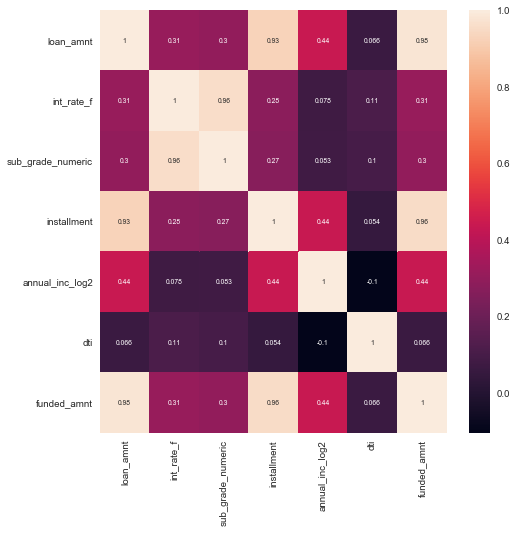

In [48]:
fig=plt.figure(figsize=(8, 8), dpi=70, facecolor='w', edgecolor='k')
sns.set(style="darkgrid")
sns.heatmap(loan_data_corr, annot=True, annot_kws={"size": 7})
plt.show()

### Observation  
From the above , it is clear that int_rate, sub grades and grades are related strongly. <br>
For analysis, we will drop 'Grade' and 'Subgrade' and use Interest.

### Delete Unnecessary cols
The following are the main assumptions - 
 - Columns that have unique values for each of the observation are dropped.These are system identifiers
    provided to the applications. For example 'id','member_id'<br>
 - Columns that do not add any value to the Analysis are dropped, for example - 'last_pymnt_amnt'
 - Columns that are generally not the cause ( but are effect) of loan status are dropped, for example 'total_rec_prncp'
 - Columns that are highly correlated to the other variables are dropped for example 'grade','sub_grade','int_rate'
 - Columns that have been cleaned and derived for example - int_rate_f is derived from int_rate, similarly,
   'income verification' and 'source verification' derived from 'verification status'

In [49]:
#Drop columns that do not add any weight to the analysis
loan_data.drop(columns=['member_id','funded_amnt_inv','grade','sub_grade','emp_title',
                        'issue_d','url','desc','int_rate','open_acc','revol_bal','total_acc',
                       'purpose','title','zip_code','addr_state','earliest_cr_line',
                       'earliest_cr_line_dt','time_delta','out_prncp','out_prncp_inv','total_pymnt',
                       'total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee',
                       'recoveries','collection_recovery_fee','last_pymnt_amnt','city_code',
                        'last_credit_pull_d', 'last_credit_pull_dt','sub_grade_numeric','earliest_cr_line_dt_fine',
                       'last_pymnt_d','verification_status'],
                        axis=1,inplace=True)

In [50]:
# Extract fully paid and charged off loans for Segmented analysis
loan_data_extract=loan_data[loan_data['loan_status']!='current']
# Check Size and print few observations
print(loan_data_extract.shape)

(38523, 26)


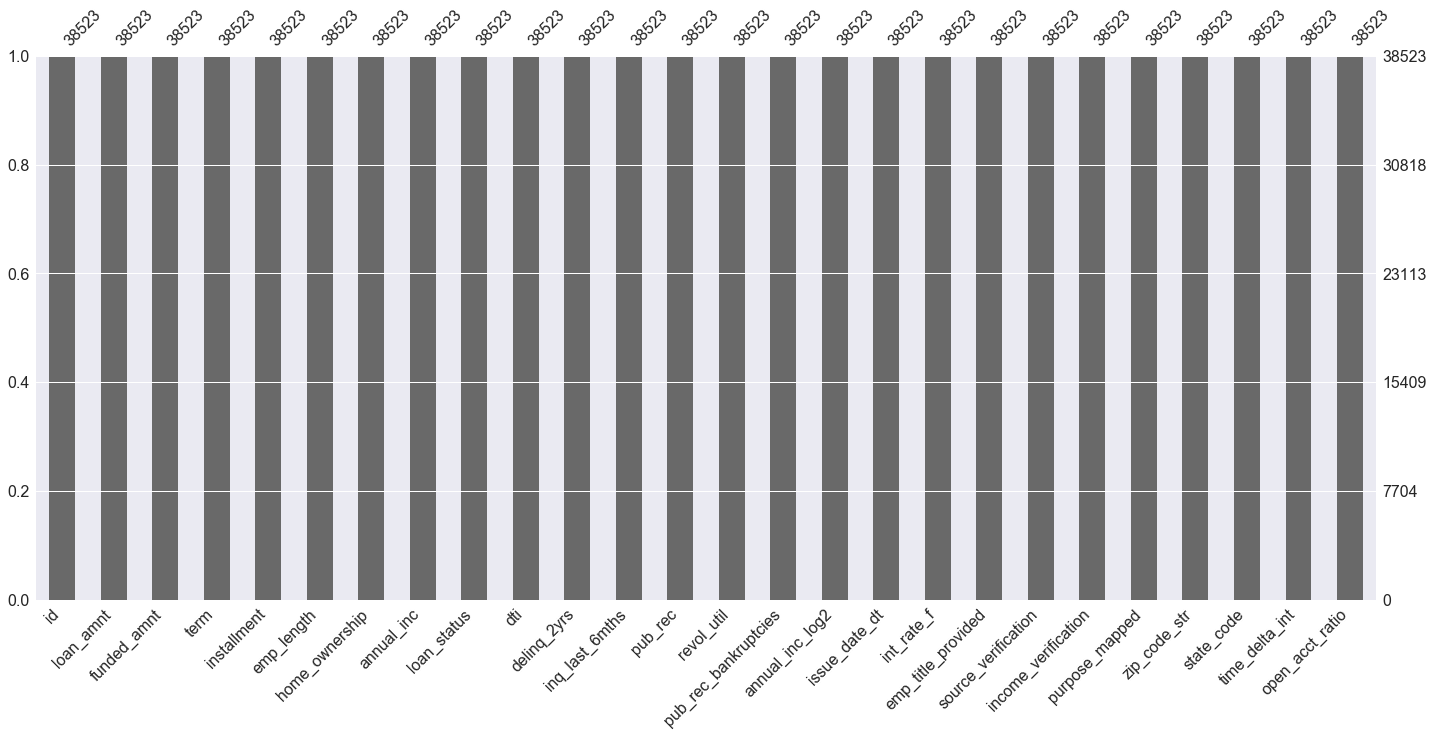

In [51]:
# Check the missing numbers
msno.bar(loan_data_extract)

## Univeriate Analysis and Segmented Analysis

Following the data Cleaning exercise, Univeriate and Segmented Analysis is done. Each Variable is considered <br>
at a time and analysis is done. Box plots, Count plot or percentage stacked plot are employed as applicable.<br>

In [52]:
# Write a function to display subplots of box plot for given variables.
def box_plot(k,fx=16,fy=8):
    fig=plt.figure(figsize=(fx, fy), dpi=70, facecolor='w', edgecolor='k')
    sns.set(style="darkgrid")
    i=1
    for col in k:
        plt.subplot(2,3,i)
        sns.boxplot(y=col,
                    x='surviv',
                palette='pastel',
                data=loan_data_extract)
        i=i+1

plt.show()

In [53]:
# Write a function to display subplots of bar plot for given variables.
def count_plot(k,fx=16,fy=8):
    fig=plt.figure(figsize=(fx, fy), dpi=90, facecolor='w', edgecolor='k')
    sns.set(style="darkgrid")
    i=1
    for col in k:
        plt.subplot(2,3,i)
        plt.xticks(rotation='vertical')
        ax=sns.countplot(y=col,
            data=loan_data_extract,
            palette='pastel',
            order=loan_data_extract[col].value_counts().index)  
        i=i+1
    
    
plt.show()

In [54]:
# Write a function to display a percentage stacked plot of passed variable aganist the Loan Status
def stacked_plot(a,b,fx=10,fy=8):
    x_value=a
    labl=b
    loan_data_extract_totals=loan_data_extract.groupby(by=[x_value,'loan_status'])['loan_amnt'].count().reset_index()
    loan_analysis_totals=pd.pivot_table(loan_data_extract_totals,values='loan_amnt',index=x_value,columns='loan_status').reset_index()
    
    r = range(len(loan_analysis_totals[x_value]))
    
    loan_total = [i+j for i,j in zip(loan_analysis_totals['charged off'],loan_analysis_totals['fully paid'])]
    loan_chgoff = [i / j * 100 for i,j in zip(loan_analysis_totals['charged off'], loan_total)]
    loan_paid = [i / j * 100 for i,j in zip(loan_analysis_totals['fully paid'], loan_total)]
     
    df_percents=pd.DataFrame({x_value:loan_analysis_totals[x_value],'Charged_off_perc':loan_chgoff,'Fully_paid_p':loan_paid})
    #print(df_percents)
    
    sns.set(style="ticks")
    col_mat=['b','r','g','y','c','m']
    m=np.random.randint(1,5)
    
    #ax=df_percents.plot.bar(stacked=True,figsize=(fx,fy),color=sns.color_palette("hls", 8))
    ax=df_percents.plot.bar(stacked=True,figsize=(fx,fy),color=[col_mat[m],col_mat[m-1]])
    
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        if height!=0:
            ax.annotate('{:.2f} %'.format(height), (p.get_x()+.25*width, p.get_y()+.5*height),ha='left',va='center',
                    rotation='vertical',
                    size='smaller')   
       
    plt.xticks(r,loan_analysis_totals[x_value],rotation='vertical')
    plt.xlabel(labl)
    plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=1)
    plt.show()

## Analyse Loan Amount - The amount customer has requested 

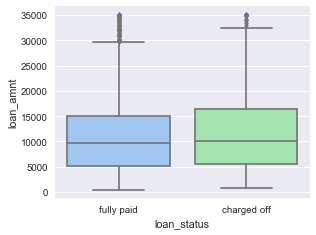

In [55]:
box_plot(['loan_amnt'])

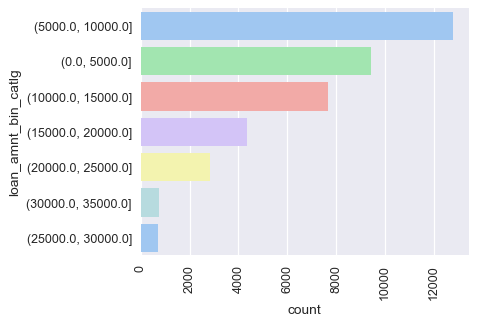

In [56]:
# Bin the loan amount into buckets and chart the plots 
loan_data_extract['loan_amnt_bin_catlg'] = pd.cut(loan_data_extract['loan_amnt'], np.linspace(0, 35000, 8))
count_plot(['loan_amnt_bin_catlg'])

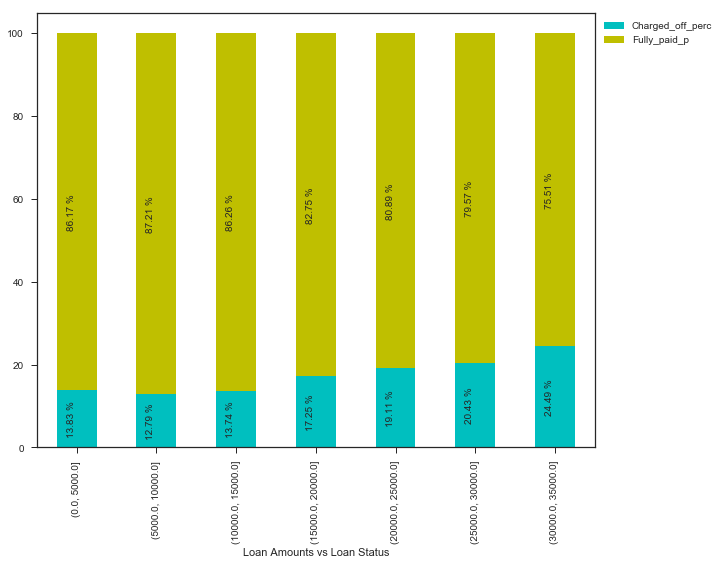

In [57]:
stacked_plot('loan_amnt_bin_catlg','Loan Amounts vs Loan Status')

### Observation
In general, as the loan amount is increasing, the percentage of the charged off loans is increasing.<br>
The percentage of Charged off loans is highest for the loam amounts in range 30000 - 35000. But, the number of loans in this category are less.<br>
From the count plot, the highest number of loans is for 5000 - 10000, followed by 0 - 5000 and 10000 - 15000.
With in top 3 high volume categories, the laons that all with in 0 -5000 are slightly likely to be charged off 


## Analyse impact of Funded Amount on Loan Status

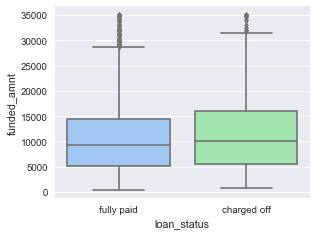

In [58]:
box_plot(['funded_amnt'])

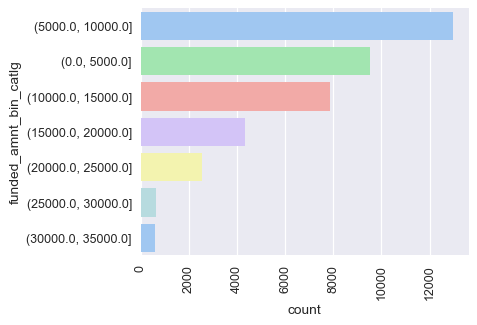

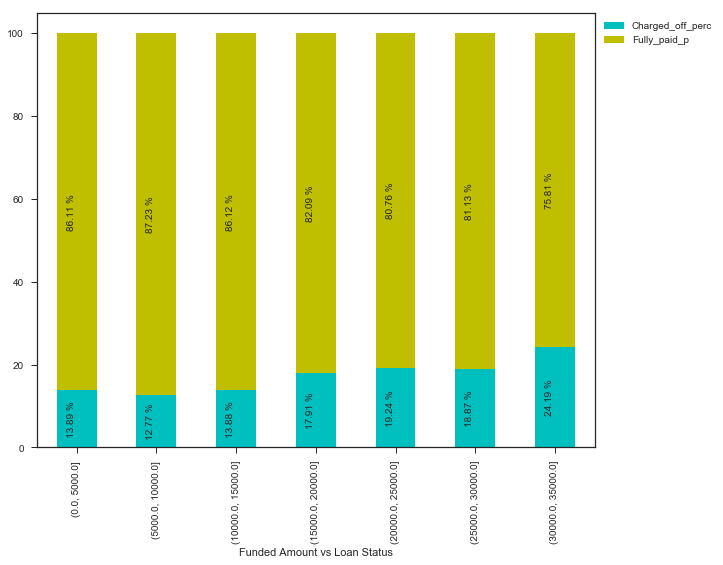

In [59]:
# Bin the funded amount and chart the plots
loan_data_extract['funded_amnt_bin_catlg'] = pd.cut(loan_data_extract['funded_amnt'], np.linspace(0, 35000, 8))
count_plot(['funded_amnt_bin_catlg'])
stacked_plot('funded_amnt_bin_catlg','Funded Amount vs Loan Status')

### Observation
The trend of funded Amount closely matches the loan amount. Both these values are stringly correlated.

#### Note
An interesting analysis - check the trend of charged off loans when the funded amount is less than the amount applied for,<br>
by the applicant.

In [60]:
# Create a flag to indicate if the funded amount is same as Applicant requested Amount
loan_data_extract['full_amnt_given'] = np.where(loan_data_extract['loan_amnt'] == loan_data_extract['funded_amnt'], True, False)
loan_data_extract['full_amnt_given'] = loan_data_extract['full_amnt_given'].apply(lambda x:'Issued Applied Amount' if x is True else 'Issued Reduced Amount')

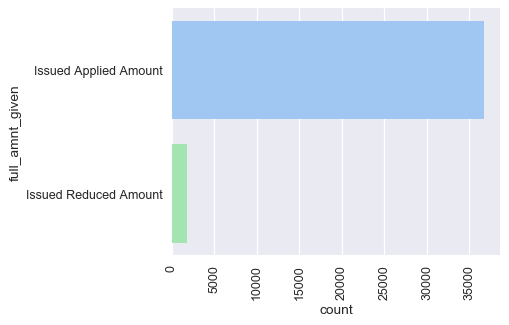

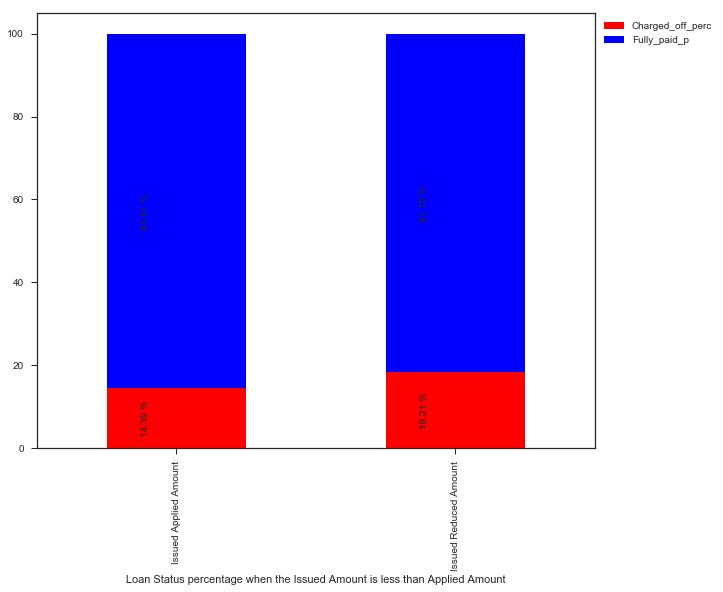

In [61]:
count_plot(['full_amnt_given'])
stacked_plot('full_amnt_given','Loan Status percentage when the Issued Amount is less than Applied Amount')

### Observation
From the charts, it is evident that applications that have Funded Amount less than the customer applied amount, are marginally likely <br>
to be charged off. 

## Term - Tenure of the loan - 36 Months or 60 Months 

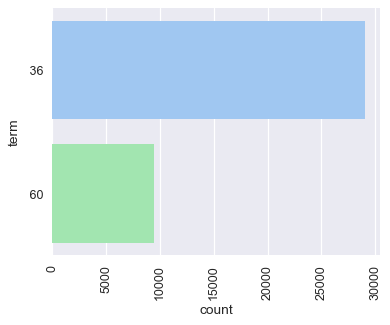

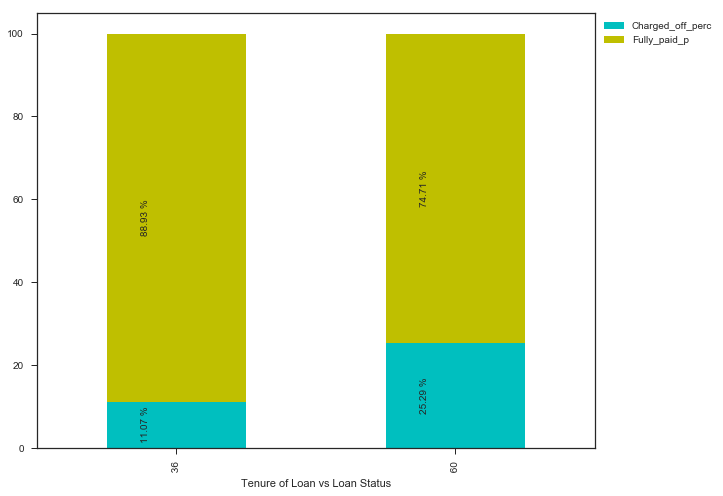

In [62]:
count_plot(['term'])
stacked_plot('term','Tenure of Loan vs Loan Status')

### Observation 
Loans with longer tenure have high percentage of Charge Off applications. This indicates that customers who have longer <br>
commitments opted charge off due to varying financial circumstances over the time.

## Interest Rate of the loan

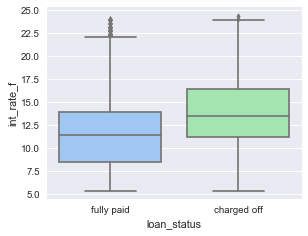

In [63]:
box_plot(['int_rate_f'])

In [64]:
# Bin the Interest Rates into categories and chart the plot.
loan_data_extract['int_rate_bin']=pd.cut(loan_data_extract['int_rate_f'], np.linspace(5, 25, 5))

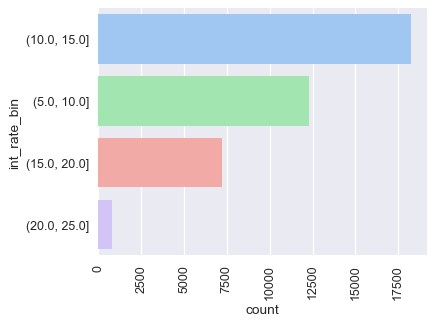

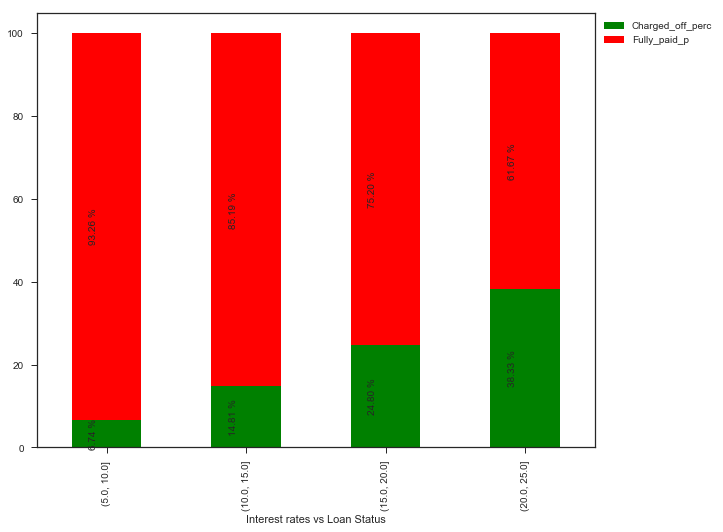

In [65]:
count_plot(['int_rate_bin'])
stacked_plot('int_rate_bin','Interest rates vs Loan Status')

### Observation
In general, the higher the interest rate is, the higher is the percentage of Charged off Loans. <br>
Loans with in interest rate 10 -15 are most frequent, followed by those with  5-10 and 15-20.<br>
However, the percentage of chareged Offs is high in 10-15, followed by 5-10. <br>
This analysis evidences, that there is some risk in issuing the High Interest Loans and additional due deligence is required while processing loan applications

## Analyse Dti - Debit to Income Ratio 

In [66]:
# Bin the DTI into categories and chart the plots.
loan_data_extract['dti_bin']=pd.cut(loan_data_extract['dti'], np.linspace(0, 30, 7))

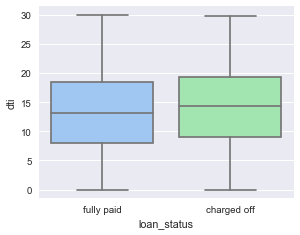

In [67]:
box_plot(['dti'])

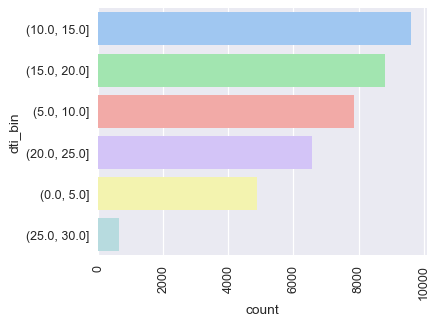

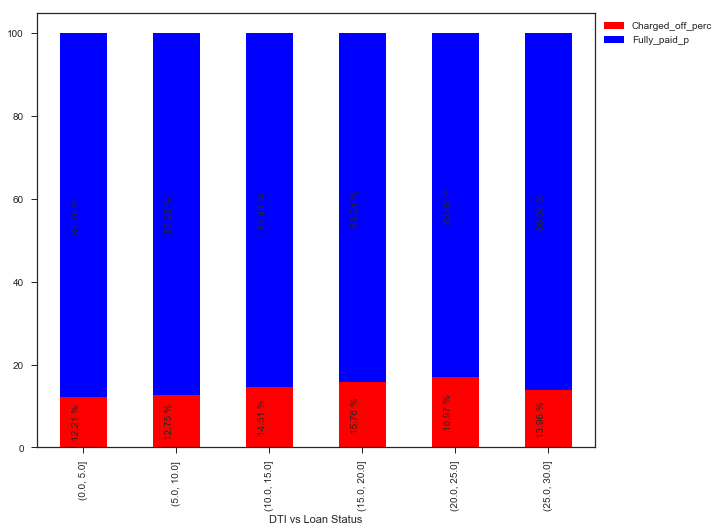

In [68]:
count_plot(['dti_bin'])
stacked_plot('dti_bin','DTI vs Loan Status')

### Observation
The percentage of charged off loans is increasing as the dti increases.<br>
Also, from box plot, it is evident,that dti is higher in charged off loans. <br>
While dti in 10-15 is frequent observation, the percentage of charge offs are higher in 15-20. <br>
This evidences, that high dti meant a risky loan application.

## Analyse Credit History - The difference in the issue date and earliest credit date 

In [69]:
# Bin the calculated credit age and then chart the plot
loan_data_extract['time_delta_bin'] = pd.cut(loan_data_extract['time_delta_int'], np.linspace(2, 65, 22))

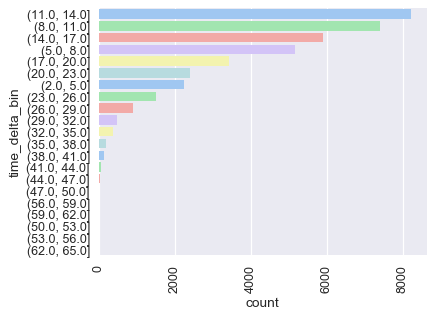

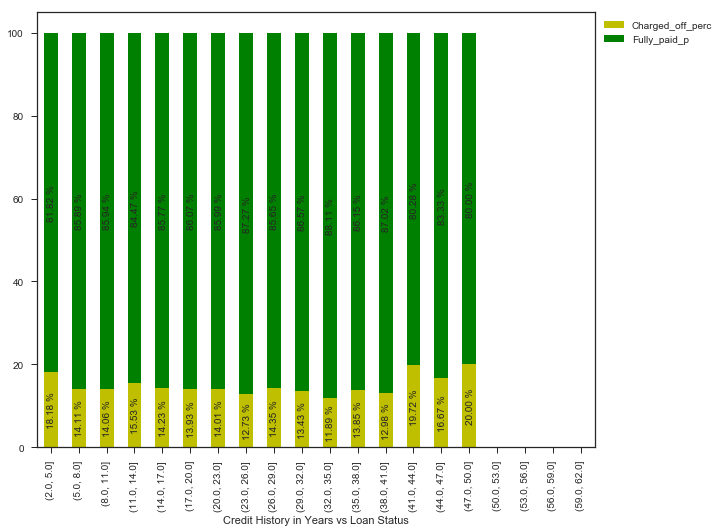

In [70]:
count_plot(['time_delta_bin'])
stacked_plot('time_delta_bin','Credit History in Years vs Loan Status')

### Observations
There is a mixed trend in the charged off loans when plotted against the credit age. <br>
In general, a very low credit age meant, the financial profile of the applicant is not clear. <br>
A high credit age meant, the financial profile of the applicant is superseded by the age of the application. <br>
This trend is clearly visible in the above percentage stacked plot.

## Analyse Home Ownership Status and its impact on Loan Status

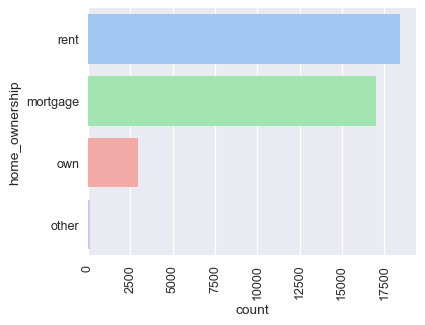

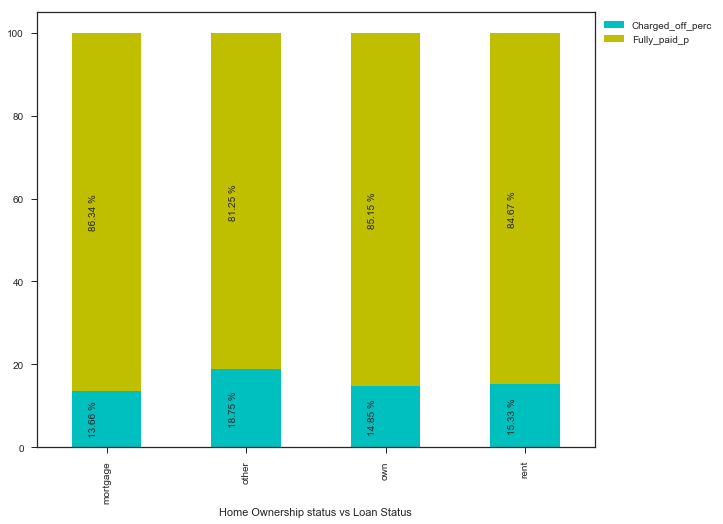

In [71]:
count_plot(['home_ownership'])
stacked_plot('home_ownership','Home Ownership status vs Loan Status')

### Observation
The home ownership with 'other' are charging off the loans at higher rate. <br>
This shows that 'other' category of the home ownership should be identified as risk. Further checks are required to understand <br>
the residency status.

## Analyse Annual Income impact on Loan Status

In [72]:
#Bin the Annual Income and chart the plots.
loan_data_extract['annual_inc_bin'] = pd.cut(loan_data_extract['annual_inc_log2'], np.linspace(10, 23, 5))

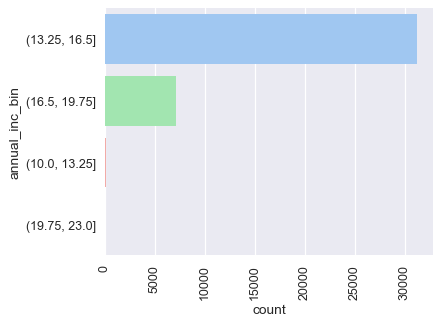

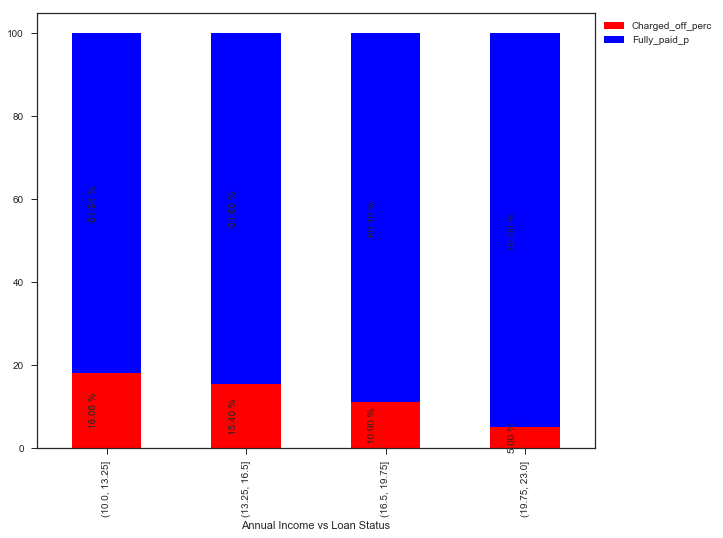

In [73]:
count_plot(['annual_inc_bin'])
stacked_plot('annual_inc_bin','Annual Income vs Loan Status')

### Observation
The general trend is, as the annual income increases, the percentage of charged off loans decreases. <br>
This is eveident from the fact that loans in the range 16.5 - 19.75 have lower charged off percentage compared to 13.25 - 16.5 <br>
which is highly frequent.

## Analyse Year of Issue and trend of charged off loans

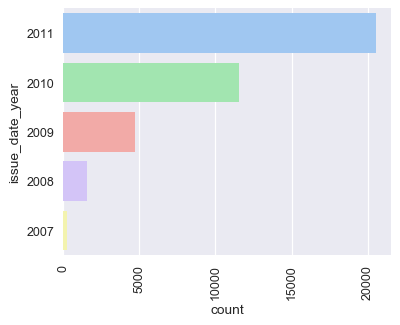

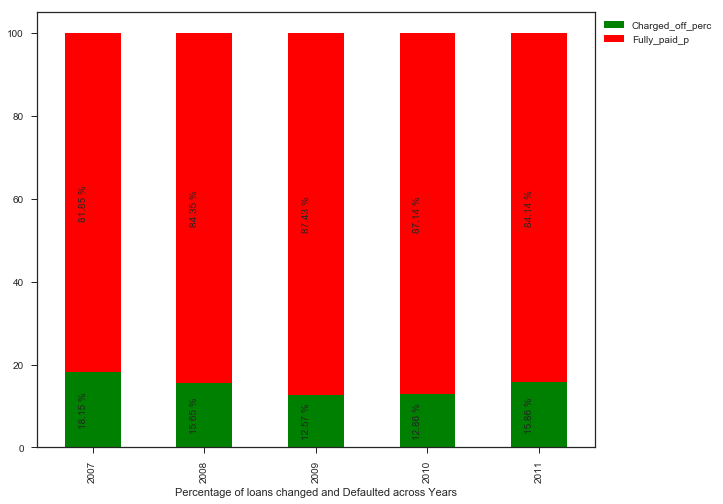

In [74]:
# Extract the year from formatted Issue date and chart the plots for analysis
loan_data_extract['issue_date_year']=loan_data_extract['issue_date_dt'].dt.year
loan_data_extract['issue_date_year']=loan_data_extract['issue_date_year'].astype(str)
count_plot(['issue_date_year'])
stacked_plot('issue_date_year','Percentage of loans changed and Defaulted across Years')

### Observation 
The number of loans gradually increased from 2007 till 2011 <br>
However, the percentage of the charge off loans issued have reduced from 2007 till 2010. <br>
In 2011, there is high charge off rate. This could be partly due to number of loans issued. <br> 
Further analysis will be required to draw any conclusions on this behavior. 

### Analyse pub_rec - Number of derogatory comments on the credit file

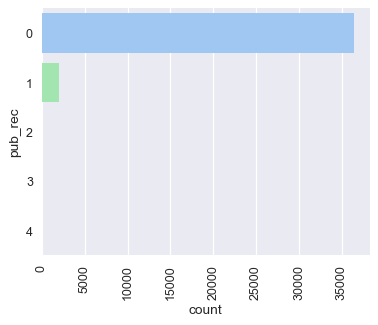

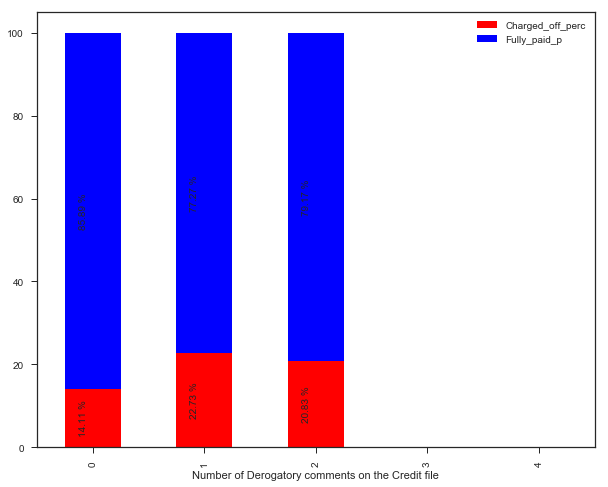

In [75]:
loan_data_extract.pub_rec=loan_data_extract.pub_rec.astype(str)
count_plot(['pub_rec'])
stacked_plot('pub_rec','Number of Derogatory comments on the Credit file')

### Observation
It is evident from the above chart that, the higher the derogatory comments are, the higher is the charge off rate.

### Analyse pub_rec_bankruptcies - Number of public bankruptcies on the credit file

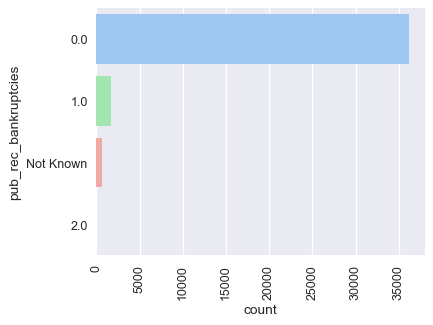

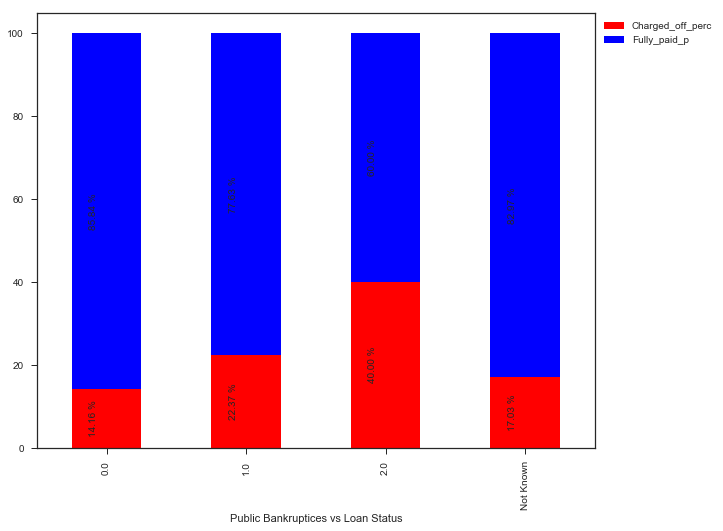

In [76]:
count_plot(['pub_rec_bankruptcies'])
stacked_plot('pub_rec_bankruptcies','Public Bankruptices vs Loan Status')

### Observation
It is evident from the above chart that, the higher the bankruptcies are, the higher is the charge off rate.

### Analyse Source and Income Verification

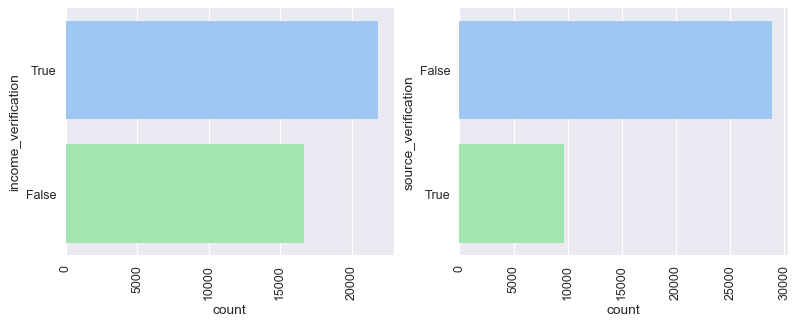

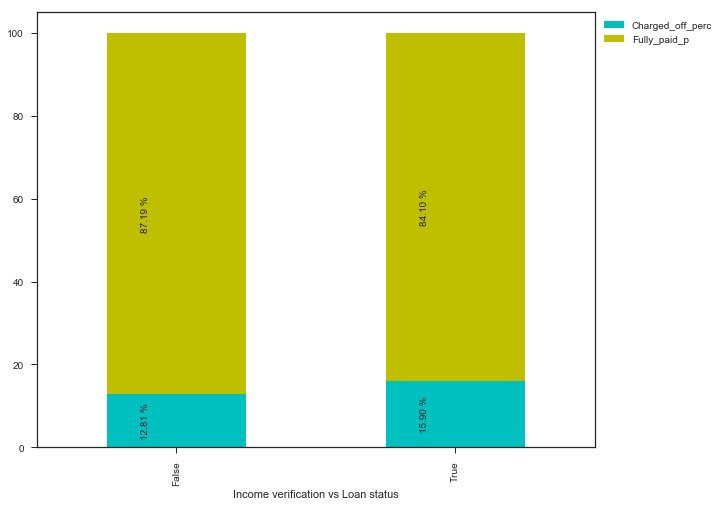

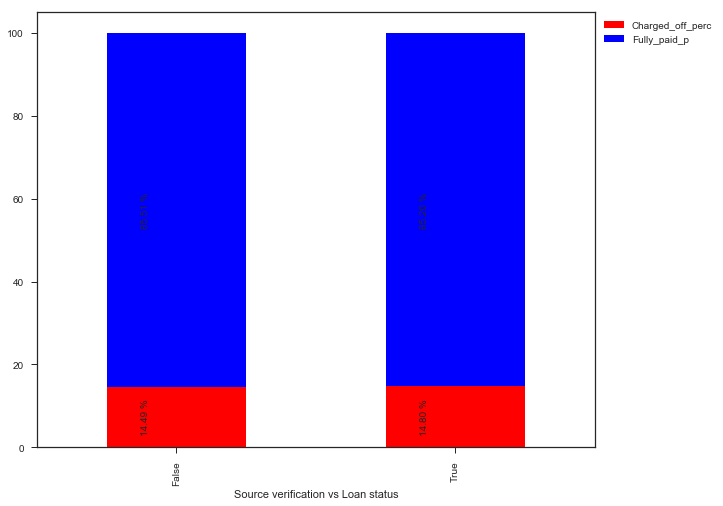

In [77]:
count_plot(['income_verification','source_verification'])
stacked_plot('income_verification','Income verification vs Loan status')
stacked_plot('source_verification','Source verification vs Loan status')

### Observation
In the analysis of Source Verification, apparently there is no effect on the charged off rate, even though there is stark difference in the counts.<br>
In case of Income verification, the charge off rate is higher ,when the income has been verified.<br>
This shows, that income verification checks have no effect in case of Risky applications. The income verification process <br>
will need to be reviewed.

### Analyse Purpose mentioned by customer on the application

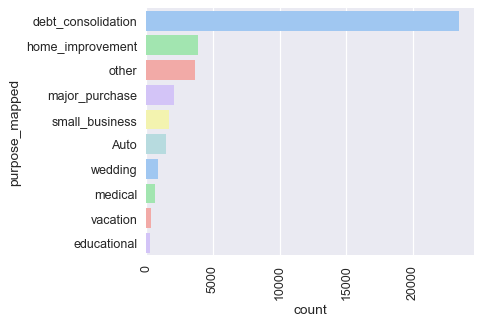

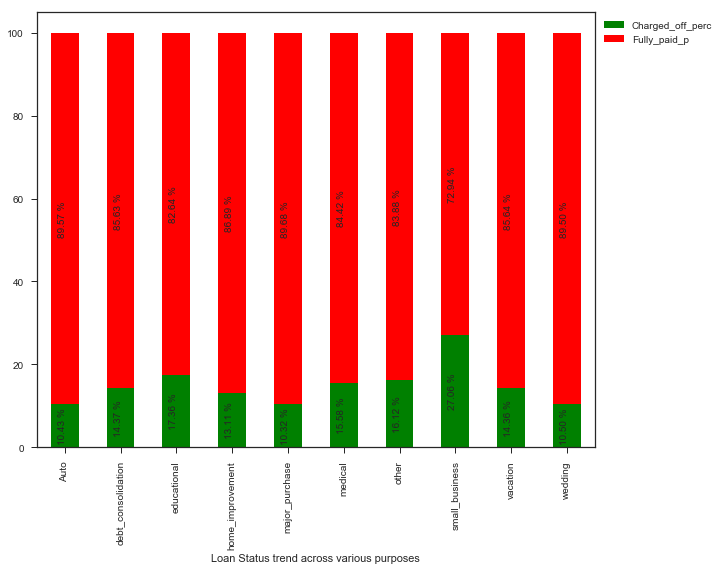

In [78]:
count_plot(['purpose_mapped'])
stacked_plot('purpose_mapped','Loan Status trend across various purposes')

### Observation
In general, the unsecured loans - like the small business loans, followed by educational loans are highly charged off. <br>
Debit Consolidation is the most common purpose

### Analyse the employee title diclosure impact on loan status

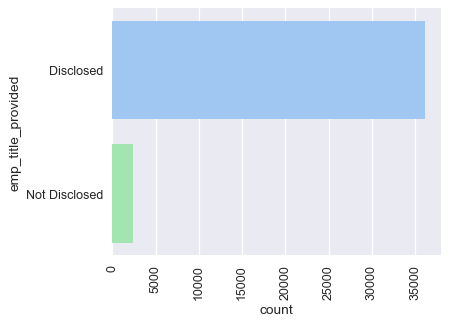

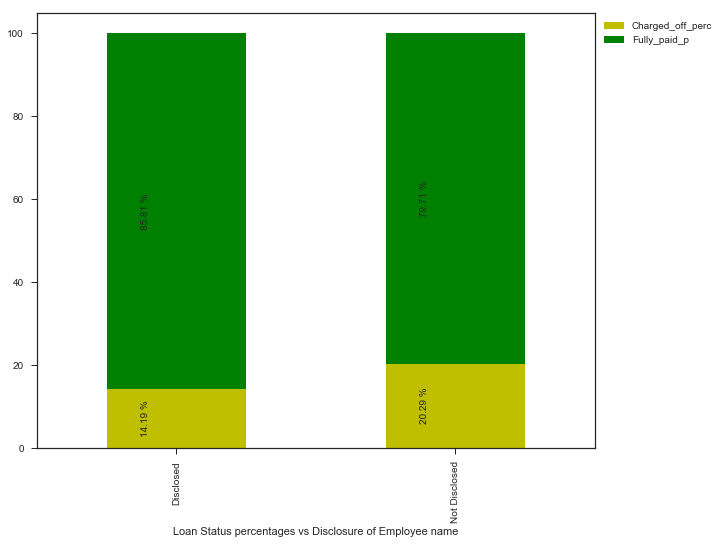

In [79]:
count_plot(['emp_title_provided'])
stacked_plot('emp_title_provided','Loan Status percentages vs Disclosure of Employee name')

### Observation
Apparently, the rate of charged off applications are higher in cases, where the Employee title was not disclosed.<br>
However, the 'Not Disclosed' is much less compared to 'Disclosed' category and that could have some bearing on this trend. <br>
Further Analysis will be required on Employee title to draw logical conclusions.

### Analyse the trend of Inquiries in past 6 months 

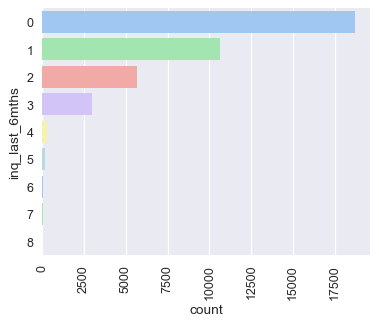

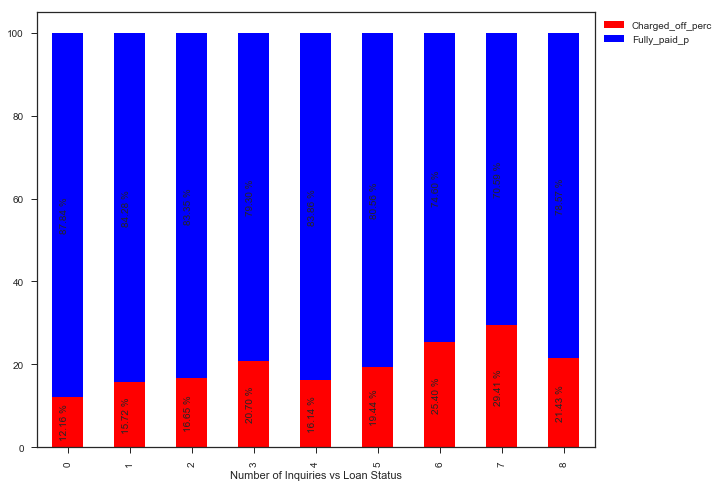

In [80]:
loan_data_extract.inq_last_6mths=loan_data_extract.inq_last_6mths.astype(str)
count_plot(['inq_last_6mths'])
stacked_plot('inq_last_6mths','Number of Inquiries vs Loan Status')

### Observation
Considering both the count plot and stacked percentage plot, it is evident that, the higher the number of inquiries, the higher <br>
is the rate of charge off.  This parameter shows the desperation of the customer for a credit line.

### Analyse the Employment Length vs Loan status

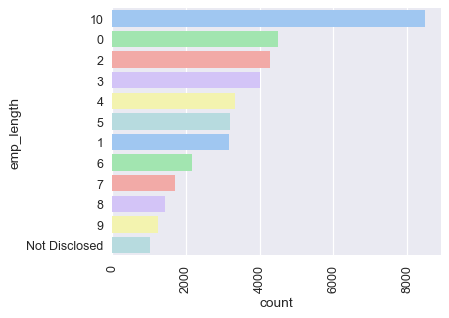

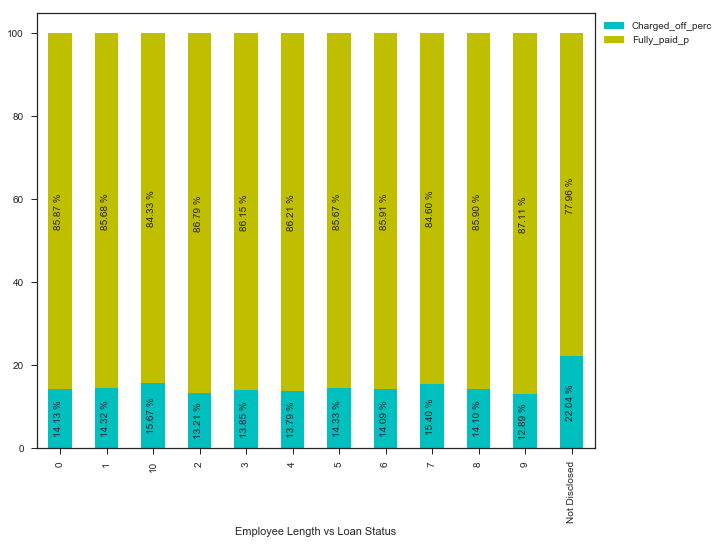

In [81]:
loan_data_extract.emp_length=loan_data_extract.emp_length.astype(str)
count_plot(['emp_length'])
stacked_plot('emp_length','Employee Length vs Loan Status')

### Observation
There is no clear trend of employment length impact on the charged off rate. Further investigation will be required to study <br>
this variable

### Analyse the trend of Installment across the loan status

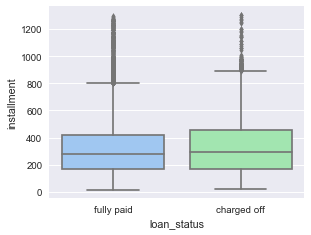

In [82]:
box_plot(['installment'])

In [83]:
#Bin the log of installements into ranges and chart the plots.
loan_data_extract['installment_bin'] = pd.cut(np.log2(loan_data_extract['installment']), np.linspace(3.5, 10.5, 8))

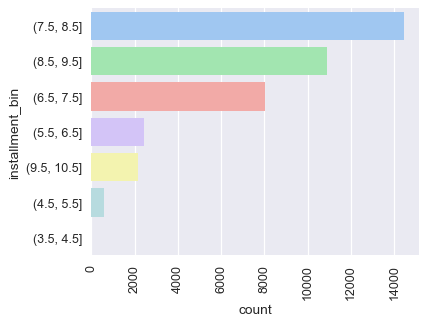

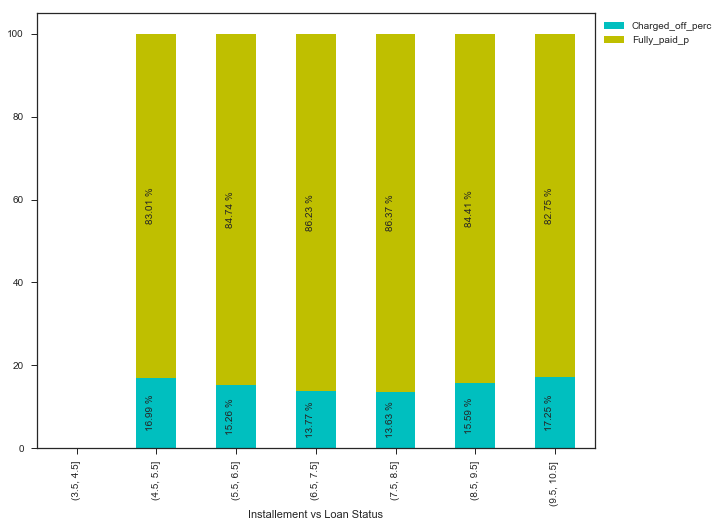

In [84]:
count_plot(['installment_bin'])
stacked_plot('installment_bin','Installement vs Loan Status')

### Observation 
From both the count plot and stacked plot it is evident that as the instalment increases, the rate of charge off loans increases.<br>
Loans with instalments in range 7.5 - 8.5 are common followed by 8.5 - 9.5 and 6.5 - 7.5. <br>
Rate of charge off is marginally higher in 8.5 - 9.5

### Analyse Open Account Ratio vs Loan Status

In [85]:
loan_data_extract['open_acct_ratio_bin'] = pd.cut(loan_data_extract['open_acct_ratio'], np.linspace(0, 1, 6))

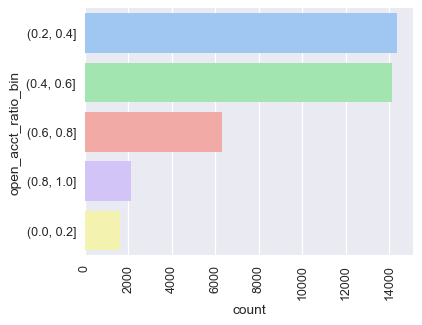

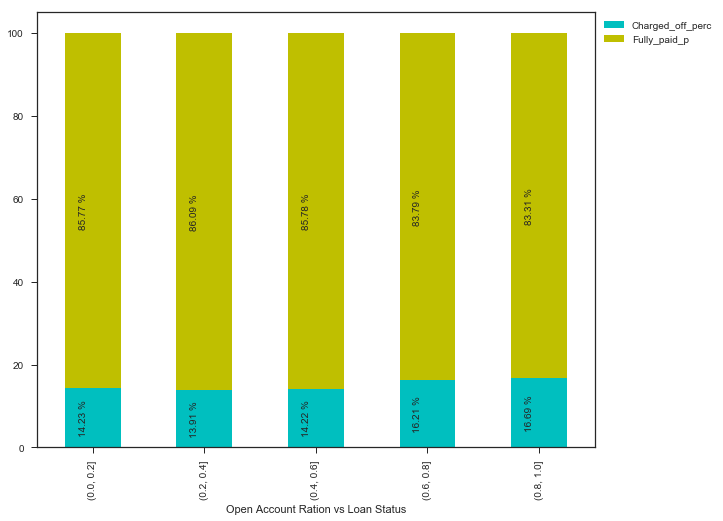

In [86]:
count_plot(['open_acct_ratio_bin'])
stacked_plot('open_acct_ratio_bin','Open Account Ration vs Loan Status')

### Observation
From the above chart, it is evident that Bank is not issuing the loans to applicants who have higher open account ratio. <br>
The general trend is, the higher the open account ratio is, the higher the chance of charging off loan

### Analyse Revolving Balance Utilization Rate

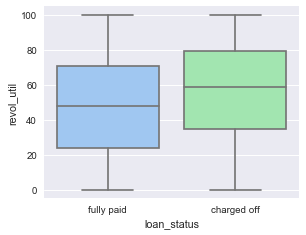

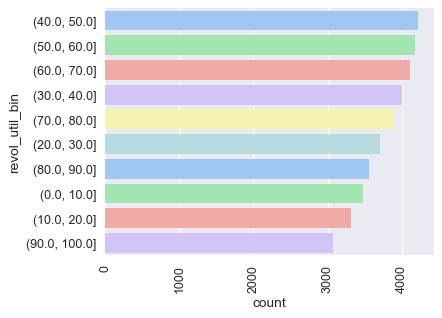

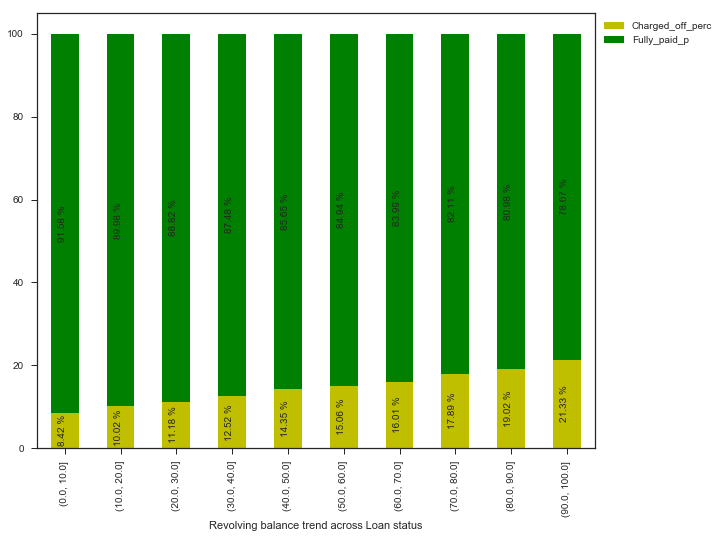

In [87]:
box_plot(['revol_util'])
loan_data_extract['revol_util_bin'] = pd.cut(loan_data_extract['revol_util'], np.linspace(0, 100, 11))
count_plot(['revol_util_bin'])
stacked_plot('revol_util_bin','Revolving balance trend across Loan status')

### Observation
From the box plot and count plot, it is evident that, revolving balance utilization is higher in charged off loans. <br>
Customers with considerable revolving balance (40 - 50) are top applicants. They are also having the high percentage of <br>
charge off loans compared with applicants with utilization rate less than 40.<br>
This general trend is  - the higher the revolving balance utilization rate, the higher is the chance of charging off loan.


### Analyse Loan trend across the state and Zip Codes

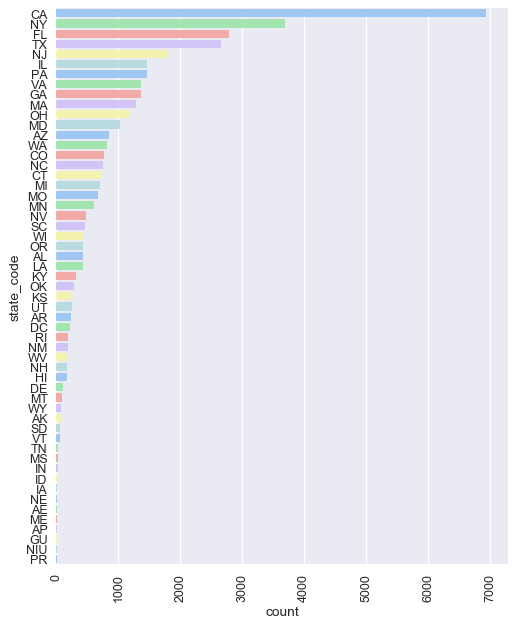

In [88]:
count_plot(['state_code'],22,18)

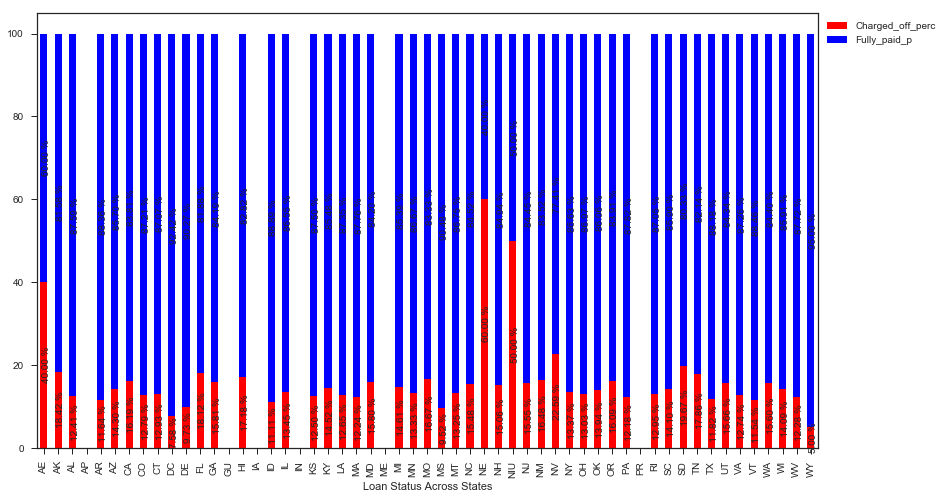

In [89]:
stacked_plot('state_code','Loan Status Across States',14,8)

### Observation
As per the above state 'CA' has highest number of charged off applications. <br>
In terms of percentages, the loans are highly charged off in the state NE,NIU and AE. <br>
Observing the number of loans applied from each of these states, it is clear, that the number of applications are less and hence<br>
this behavior. Excluding the above outlier behavior, the state with highest charged off percentage is NV - Nevada.

Analyse further on the zip codes and state codes

In [90]:
# take those states and zip codes, that have applciations mroe than 200. Calculate the percentage of charged off loans
temp_dataframe=loan_data_extract.groupby(by=['state_code','zip_code_str','loan_status']).count().reset_index()[['state_code','zip_code_str','loan_status','loan_amnt']]
temp_dataframe=pd.pivot_table(temp_dataframe,values='loan_amnt',index=['state_code','zip_code_str'],columns=['loan_status']).reset_index()
temp_dataframe=temp_dataframe[temp_dataframe['charged off']+temp_dataframe['fully paid'] >= 200]
temp_dataframe['charged off perc']=temp_dataframe['charged off']/(temp_dataframe['charged off']+temp_dataframe['fully paid'])*100
temp_dataframe=temp_dataframe.sort_values('charged off perc',ascending=False)
temp_dataframe.rename(columns={'loan_status':'Cumulative_Count'}, inplace=True)
temp_dataframe=temp_dataframe.reset_index().rename(columns={'index':'Counts'})
temp_dataframe

loan_status  Counts state_code zip_code_str  charged off  fully paid  \
0               476         NV          891        64.00      177.00   
1                71         CA          917        71.00      269.00   
2               156         FL          331        70.00      267.00   
3               155         FL          330        51.00      198.00   
4                79         CA          925        47.00      185.00   
5               455         NJ          080        45.00      190.00   
6                67         CA          913        50.00      215.00   
7                80         CA          926        67.00      299.00   
8                82         CA          928        34.00      168.00   
9               499         NY          117        49.00      244.00   
10               77         CA          923        33.00      167.00   
11              159         FL          334        37.00      192.00   
12               46         AZ          852        42.00      225.00   
13               57         CA          902        36.00      193.00   
14               96         CA          945        80.00      451.00   
15              495         NY          113        41.00      233.00   
16               75         CA          921        51.00      290.00   
17               56         CA          900        64.00      381.00   
18              445         NJ          070        65.00      389.00   
19              686         TX          770        44.00      271.00   
20              102         CA          951        30.00      189.00   
21              171         GA          300        52.00      331.00   
22              758         WA          980        29.00      188.00   
23              494         NY          112        65.00      437.00   
24               74         CA          920        28.00      193.00   
25              482         NY          100        70.00      513.00   
26              174         GA          303        26.00      191.00   
27              486         NY          104        24.00      181.00   
28              209         IL          606        48.00      445.00   
29              309         MA          021        34.00      349.00   
30              666         TX          750        30.00      326.00   
31               93         CA          941        29.00      325.00   
32              722         VA          201        17.00      206.00   
33              140         DC          200        15.00      194.00   

loan_status  charged off perc  
0                       26.56  
1                       20.88  
2                       20.77  
3                       20.48  
4                       20.26  
5                       19.15  
6                       18.87  
7                       18.31  
8                       16.83  
9                       16.72  
10                      16.50  
11                      16.16  
12                      15.73  
13                      15.72  
14                      15.07  
15                      14.96  
16                      14.96  
17                      14.38  
18                      14.32  
19                      13.97  
20                      13.70  
21                      13.58  
22                      13.36  
23                      12.95  
24                      12.67  
25                      12.01  
26                      11.98  
27                      11.71  
28                       9.74  
29                       8.88  
30                       8.43  
31                       8.19  
32                       7.62  
33                       7.18

### Observation
So with in a state , based on the urban area, the percentage of the defaulted loans is varying. <br> 
For example, with in 'FL' the zip code 331 has highest percentage of the defaulters.

### Analyse the observations using the variable  'delinq_2yrs' 

In [91]:
loan_data_extract.delinq_2yrs=loan_data_extract.delinq_2yrs.astype(str)

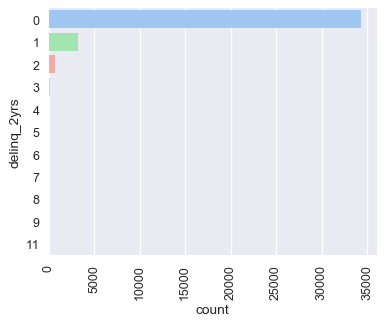

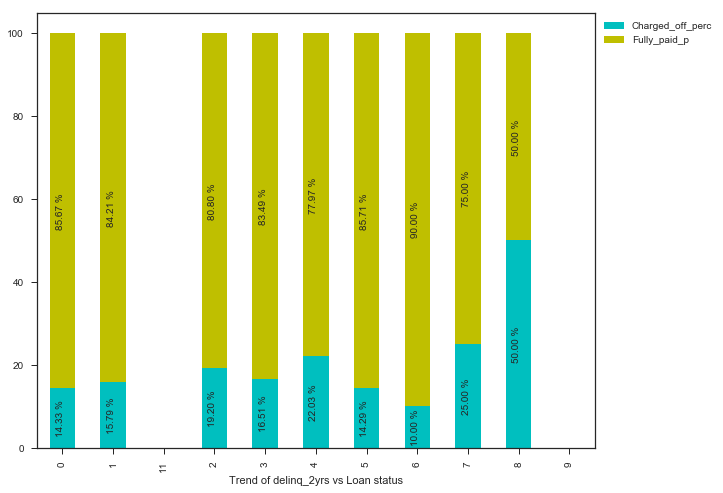

In [92]:
count_plot(['delinq_2yrs'])
stacked_plot('delinq_2yrs','Trend of delinq_2yrs vs Loan status')

### Observation
In general, LC is not accepting the customers with higher count of 'delinq_2years'. <br>
('delinq_2years' - Denotes how many 30+ days past with the incidences of delinquency  in last 2 years) <br>
The general trend is, as the count of variable increases, the percentage of charged off loans increases. <br>
There is a definite chance of charging off loan when the delinq_2years is high. Additional checks are required to understand <br>
the financial profile of the applicant in such cases. 

## Bivariate Analysis

In [93]:
#Extract charged off loans to a seperate Dataframe
loan_data_extract_chgoff=loan_data_extract[loan_data_extract['loan_status']=='charged off']

### Analyse the DTI ratio and Verification Status

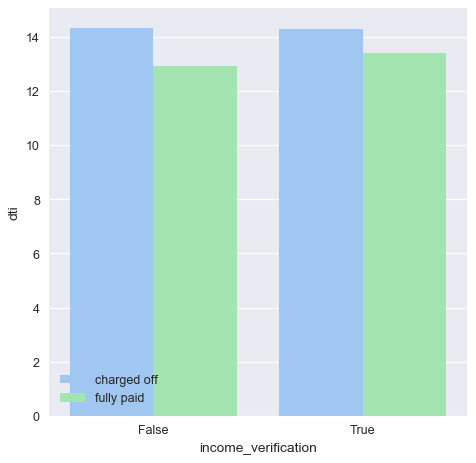

In [94]:
# Chart the plots grouping verification status and loan staus and take median of dti
fig=plt.figure(figsize=(6, 6), dpi=90, facecolor='w', edgecolor='k')
sns.set(style="darkgrid")
sns.barplot(y='dti',x='income_verification',hue='loan_status',
            palette='pastel',
            data=loan_data_extract.groupby(by=['income_verification','loan_status'])['dti'].median().reset_index())
plt.legend(loc='lower left')
plt.show()

#### Observation
From the above it is clear, that in the cases, where Debt to Income ratio is high, the income_verification is not playing a role.
In such cases, verification process should be improved to assess the application. 

### Check how the average DTI acorss the states

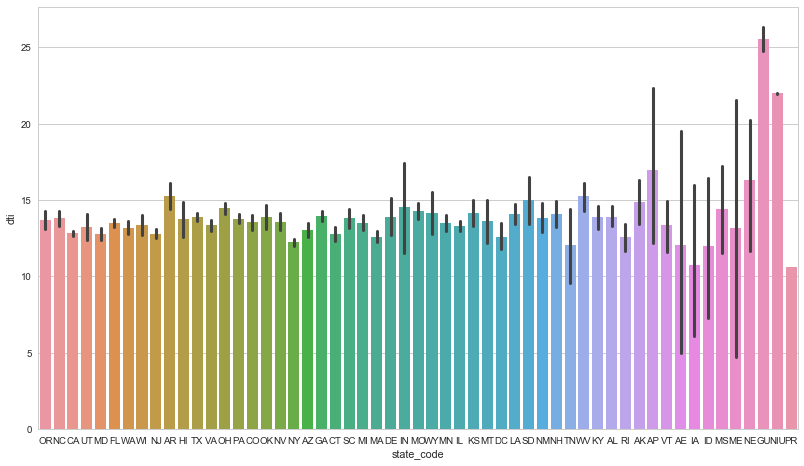

In [95]:
fig=plt.figure(figsize=(14,8), dpi=70, facecolor='w', edgecolor='k')
sns.set(style="ticks")
sns.set(style="whitegrid")
sns.barplot(x='state_code', y='dti',data=loan_data_extract)

### Observation
The Debit to Income ratio spread across the states. <br>
This shows that the error is higher in the state 'NE' that has highest percentage of chanrged off loans. <br>
The error is minimal in NV.

### Analyse the relation between loan status, home ownership and  dti.

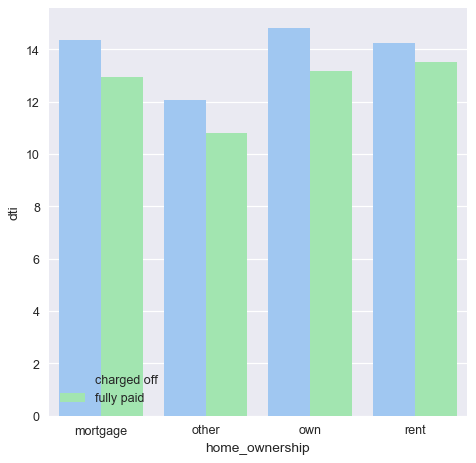

In [96]:
# Chart the plots grouping home owner ship and loan staus and take median of dti
fig=plt.figure(figsize=(6, 6), dpi=90, facecolor='w', edgecolor='k')
sns.set(style="darkgrid")
sns.barplot(y='dti',x='home_ownership',hue='loan_status',
            palette='pastel',
            data=loan_data_extract.groupby(by=['home_ownership','loan_status'])['dti'].median().reset_index())
plt.legend(loc='lower left')
plt.show()

### Observation
If the DTI is higher and the home ownership is 'own', then the percentage of defaulting loan is higher. 

### Determine any correlations from the heat map

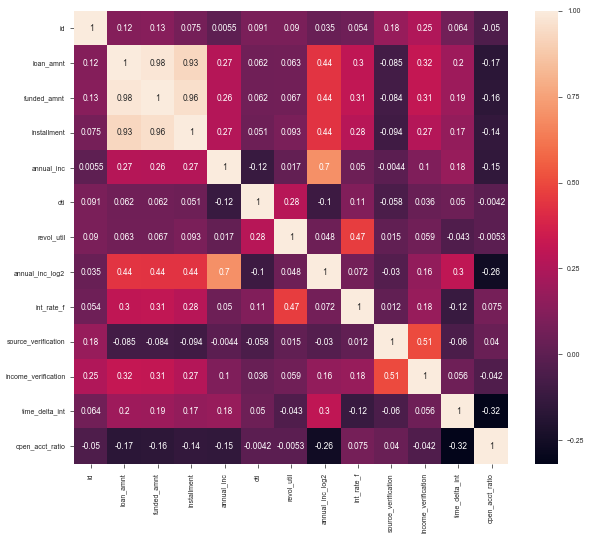

In [97]:
fig=plt.figure(figsize=(14, 12), dpi=50, facecolor='w', edgecolor='k')
sns.set(style="ticks", palette="pastel")
ax = sns.heatmap(loan_data_extract.corr(),annot=True)


### Analyse Annual income vs interest rate impact on the Charged off loans

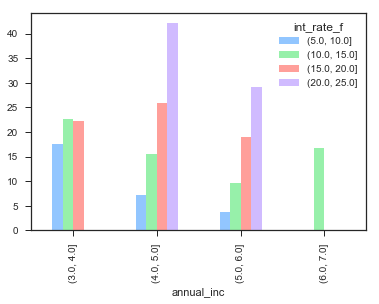

In [98]:
charged_off_income_vs_interest = pd.pivot_table(loan_data_extract_chgoff, 
                                           values='id', 
                                           index=[pd.cut(np.log10(loan_data_extract_chgoff['annual_inc']), np.linspace(3, 7, 5))], 
                                           columns=[pd.cut(loan_data_extract_chgoff['int_rate_f'], np.linspace(5, 25, 5))], 
                                           aggfunc='count', 
                                           dropna=False, 
                                           fill_value=0)

total_income_vs_interest = pd.pivot_table(loan_data_extract,
                                          values='id', 
                                           index=[pd.cut(np.log10(loan_data_extract['annual_inc']), np.linspace(3, 7, 5))], 
                                           columns=[pd.cut(loan_data_extract['int_rate_f'], np.linspace(5, 25, 5))], 
                                           aggfunc='count', 
                                           dropna=False, 
                                           fill_value=0)

charged_off_ratio_income_vs_interest = charged_off_income_vs_interest / total_income_vs_interest * 100
#charged_off_ratio_income_vs_interest.sort_index()
charged_off_ratio_income_vs_interest.plot(kind='bar')

### Observation
It is evident that - 
 - For same interest rate, charge off rate decreases with increase in annual income
 - For same income, charge off increases with increase in interest rate

## Analyse the effect of DTI and Interest Rates vs Loan status

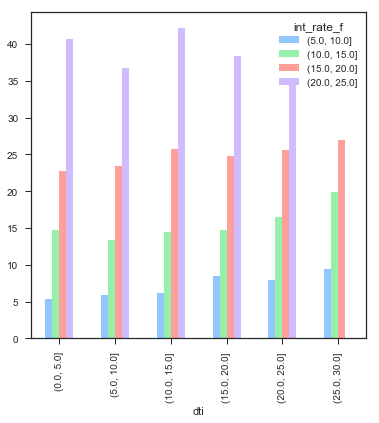

In [99]:
charged_off_dti_vs_interest = pd.pivot_table(loan_data_extract_chgoff, 
                                             values='id', 
                                             index=[pd.cut(loan_data_extract_chgoff['dti'], np.linspace(0, 30, 7))], 
                                             columns=[pd.cut(loan_data_extract_chgoff['int_rate_f'], np.linspace(5, 25, 5))], 
                                             aggfunc='count', 
                                             dropna=False, 
                                             fill_value=0)

total_dti_vs_interest = pd.pivot_table(loan_data_extract, 
                                       values='id', 
                                       index=[pd.cut(loan_data_extract['dti'], np.linspace(0, 30, 7))], 
                                       columns=[pd.cut(loan_data_extract['int_rate_f'], np.linspace(5, 25, 5))], 
                                       aggfunc='count', 
                                       dropna=False, 
                                       fill_value=0)

charged_off_ratio_dti_vs_interest = charged_off_dti_vs_interest / total_dti_vs_interest * 100
#charged_off_ratio_dti_vs_interest.sort_index()
charged_off_ratio_dti_vs_interest.plot(kind='bar',figsize=(6,6))

### Observation
Apparently, for the same dti, higher interest rates result in more charge-offs<br>
Higher interest rates have significant impact on charge offs

## Annual income vs DTI

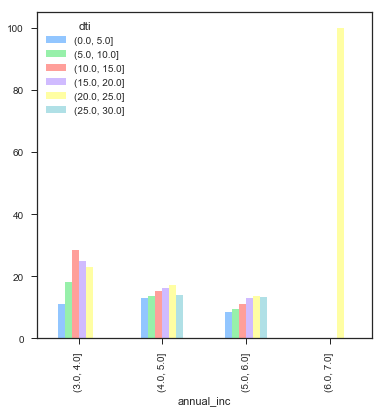

In [100]:
charged_off_income_vs_dti = pd.pivot_table(loan_data_extract_chgoff, 
                                        values='id', 
                                        index=[pd.cut(np.log10(loan_data_extract_chgoff['annual_inc']), np.linspace(3, 7, 5))], 
                                        columns=[pd.cut(loan_data_extract_chgoff['dti'], np.linspace(0, 30, 7))], 
                                        aggfunc='count', 
                                        dropna=False, 
                                        fill_value=0)

total_income_vs_dti = pd.pivot_table(loan_data_extract, values='id', 
                                           index=[pd.cut(np.log10(loan_data_extract['annual_inc']), np.linspace(3, 7, 5))], 
                                           columns=[pd.cut(loan_data_extract['dti'], np.linspace(0, 30, 7))], 
                                           aggfunc='count', 
                                           dropna=False, 
                                           fill_value=0)

charged_off_ratio_income_vs_dti = charged_off_income_vs_dti / total_income_vs_dti * 100
#charged_off_ratio_income_vs_dti.sort_index()
charged_off_ratio_income_vs_dti.plot(kind='bar',figsize=(6,6))

### Observation
- Charge off increases when DTI increases for same annual income
- Charge off decrease when salary increase for same annual income

### Analyse the Relationship of employment length/title Disclosure and Income Verification vs loan status

In [101]:
loan_data_extract['emp_length_disclosed'] = np.where(loan_data_extract['emp_length'] == 'Not Disclosed', False, True)
loan_data_extract_chgoff['emp_length_disclosed'] = np.where(loan_data_extract_chgoff['emp_length'] == 'Not Disclosed', False, True)

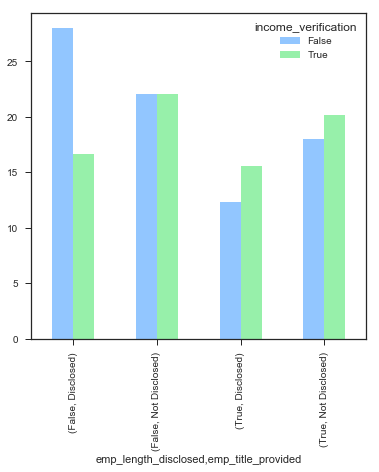

In [102]:
charged_off_rogue = pd.pivot_table(loan_data_extract_chgoff, 
                                   values='id', 
                                   index=['emp_length_disclosed','emp_title_provided'], 
                                   columns=['income_verification'], 
                                   aggfunc='count', 
                                   dropna=False, 
                                   fill_value=0)

total_rogue = pd.pivot_table(loan_data_extract, 
                             values='id', 
                             index=['emp_length_disclosed','emp_title_provided'], 
                             columns=['income_verification'], 
                             aggfunc='count', 
                             dropna=False, 
                             fill_value=0)

charged_off_rogue = charged_off_rogue / total_rogue * 100
#charged_off_rogue
charged_off_rogue.plot(kind='bar',figsize=(6,6))

### Observation
 - When employment length is disclosed and employment title is provided, charge offs are less
 - When employment title is provided and income is verified, charge offs are less
 - All other combination have a relatively high charge-off

It is good to have employee title for income verification (self employed and own business need more scrutiny). Additionally, 
when employment title is provided employment length should be expected. This will allow a higher scrutiny.